In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 

/kaggle/input/vids-for-motion-detection/Normal_Videos178_x264.mp4
/kaggle/input/vids-for-motion-detection/Normal_Videos236_x264.mp4
/kaggle/input/vids-for-motion-detection/Normal_Videos209_x264.mp4
/kaggle/input/vids-for-motion-detection/Normal_Videos244_x264.mp4
/kaggle/input/vids-for-motion-detection/Normal_Videos071_x264.mp4
/kaggle/input/vids-for-motion-detection/Normal_Videos114_x264.mp4
/kaggle/input/vids-for-motion-detection/Normal_Videos243_x264.mp4
/kaggle/input/vids-for-motion-detection/Normal_Videos020_x264.mp4
/kaggle/input/vids-for-motion-detection/Normal_Videos222_x264.mp4
/kaggle/input/vids-for-motion-detection/Normal_Videos093_x264.mp4
/kaggle/input/vids-for-motion-detection/sample_1.mp4
/kaggle/input/vids-for-motion-detection/Normal_Videos099_x264.mp4
/kaggle/input/vids-for-motion-detection/Normal_Videos149_x264.mp4
/kaggle/input/vids-for-motion-detection/Normal_Videos162_x264.mp4
/kaggle/input/ground-truth-labels/ground_truth_labels.csv


In [2]:
import cv2 as cv
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy import signal

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
video_file = '/kaggle/input/vids-for-motion-detection/Normal_Videos209_x264.mp4'

In [4]:
!ffmpeg -hide_banner -i /kaggle/input/vids-for-motion-detection/Normal_Videos209_x264.mp4

[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5d3dd2809a00] stream 0, timescale not set
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from '/kaggle/input/vids-for-motion-detection/Normal_Videos209_x264.mp4':
  Metadata:
    major_brand     : isom
    minor_version   : 512
    compatible_brands: isomiso2avc1mp41
    track           : 0
    artist          : 
    album           : 
    date            : 0
    genre           : 
    lyrics          : 
    title           : 
    encoder         : Lavf56.36.100
  Duration: 00:00:21.15, start: 0.000000, bitrate: 1732 kb/s
    Stream #0:0(und): Video: h264 (Constrained Baseline) (avc1 / 0x31637661), yuv420p, 320x240 [SAR 1:1 DAR 4:3], 1724 kb/s, 30 fps, 30 tbr, 15360 tbn, 60 tbc (default)
    Metadata:
      handler_name    : VideoHandler
    Stream #0:1(und): Audio: aac (LC) (mp4a / 0x6134706D), 44100 Hz, stereo, fltp, 3 kb/s (default)
    Metadata:
      handler_name    : SoundHandler
    Stream #0:2: Video: png, rgb24(pc), 58x38 [SAR 304:261 DAR 16:9], 90k tbr, 90k t

In [5]:
capture = cv.VideoCapture(video_file)
print(f'FPS: {capture.get(cv.CAP_PROP_FPS)}')
print(f'Start offset: {capture.get(cv.CAP_PROP_POS_FRAMES)}')
print(f'Total frames: {int(capture.get(cv.CAP_PROP_FRAME_COUNT))}')
print(f'Total seconds: {int(capture.get(cv.CAP_PROP_FRAME_COUNT) / (capture.get(cv.CAP_PROP_FPS)))}')

FPS: 30.0
Start offset: 0.0
Total frames: 633
Total seconds: 21


In [6]:
# Create background subtractor
backSub = cv.createBackgroundSubtractorKNN()

fgMask = None
masks = []

with tqdm(total=capture.get(cv.CAP_PROP_FRAME_COUNT)) as pbar:
    while True:
        ret, frame = capture.read()
    
        if frame is None:
            break

        pbar.update(1)
    
        fgMask = backSub.apply(frame)
        
        masks.append(fgMask[fgMask > 0].shape[0])

100%|██████████| 633/633.0 [00:02<00:00, 272.55it/s]


In [7]:
df = pd.DataFrame({'signal': masks})

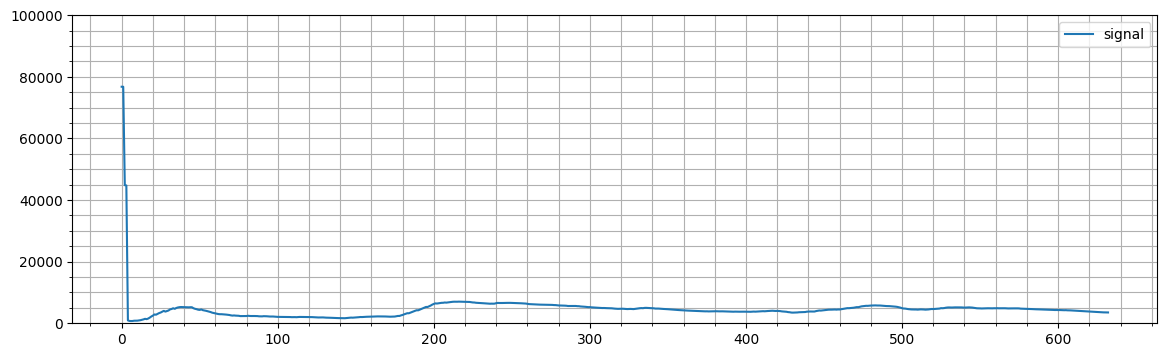

In [8]:
ax = df.plot(figsize=(14, 4))
ax.grid(axis='both', which='both')
plt.minorticks_on()
plt.ylim([0, 100000])
plt.show()

In [9]:
origin = lambda x: x
bilateral = lambda x, sigma=1<<5: cv.bilateralFilter(x, sigma, sigma * 2, sigma / 2)
gaussian = lambda x: cv.GaussianBlur(x, (5, 5), 0)
blur = lambda x: cv.blur(frame, (5, 5))
median = lambda x: cv.medianBlur(frame, 5)

filters = {
    'original': {'filter': origin, 'subtractor': cv.createBackgroundSubtractorKNN(), 'signal': []},
    'bilateral': {'filter': bilateral, 'subtractor': cv.createBackgroundSubtractorKNN(), 'signal': []},
    'blur': {'filter': blur, 'subtractor': cv.createBackgroundSubtractorKNN(), 'signal': []},
    'gaussian': {'filter': gaussian, 'subtractor': cv.createBackgroundSubtractorKNN(), 'signal': []},
    'median': {'filter': median, 'subtractor': cv.createBackgroundSubtractorKNN(), 'signal': []},
}

capture = cv.VideoCapture(video_file)
with tqdm(total=capture.get(cv.CAP_PROP_FRAME_COUNT)) as pbar:
    while True:
        # Read frame
        ret, frame = capture.read()
    
        # EOF
        if frame is None:
            break
        pbar.update(1)
    
        for filter_name in filters:
            filtered_frame = filters[filter_name]['filter'](frame)
            mask = filters[filter_name]['subtractor'].apply(filtered_frame)
            filters[filter_name]['signal'].append(mask[mask > 0].shape[0])

100%|██████████| 633/633.0 [02:09<00:00,  4.88it/s]


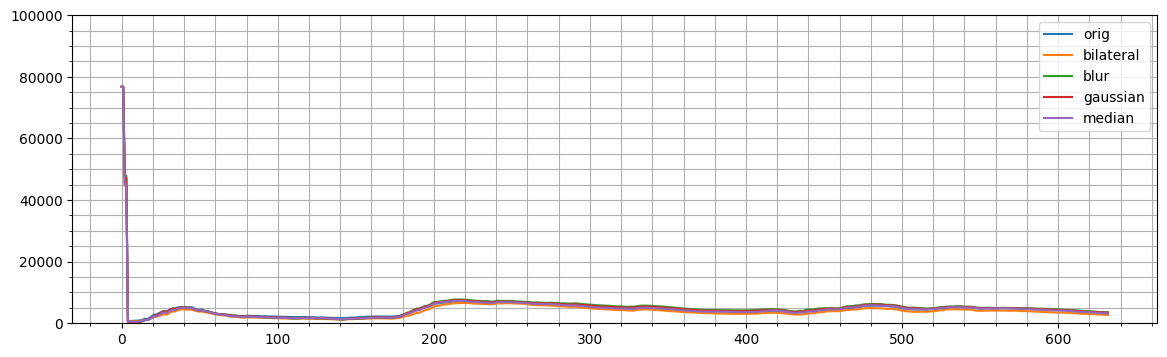

In [10]:
df = pd.DataFrame({
    'orig': filters['original']['signal'],
    'bilateral': filters['bilateral']['signal'],
    'blur': filters['blur']['signal'],
    'gaussian': filters['gaussian']['signal'],
    'median': filters['median']['signal'],
})

ax = df.plot(figsize=(14, 4))
ax.grid(axis='both', which='both')
plt.minorticks_on()
plt.ylim([0, 100000])
plt.show()

In [11]:
# Kalman
kalman_arr = []
kalman = cv.KalmanFilter(2, 1)
kalman.measurementMatrix = np.array([[1, 0]], np.float32)
kalman.transitionMatrix = np.array([[1, 0], [0, 1]], np.float32)
kalman.processNoiseCov = np.array([[1, 0], [0, 1]], np.float32) * 0.03

# Add kalman data storage
filters.update({
    'kalman': {'filter': None, 'subtractor': None, 'signal': []},
})
# Reset blur filter data storage
filters['blur']['signal'] = []

capture = cv.VideoCapture(video_file)

with tqdm(total=capture.get(cv.CAP_PROP_FRAME_COUNT)) as pbar:
    while True:
        # Read frame
        ret, frame = capture.read()
    
        # EOF
        if frame is None:
            break
        pbar.update(1)
    
        filtered_frame = filters['blur']['filter'](frame)
        mask = filters[filter_name]['subtractor'].apply(filtered_frame)
        filters['blur']['signal'].append(mask[mask > 0].shape[0])

        measurement = np.array([np.float32(mask[mask > 0].shape[0])])

        kalman.correct(measurement)
        prediction = kalman.predict()
        filters['kalman']['signal'].append(prediction[0][0])

100%|██████████| 633/633.0 [00:02<00:00, 245.00it/s]


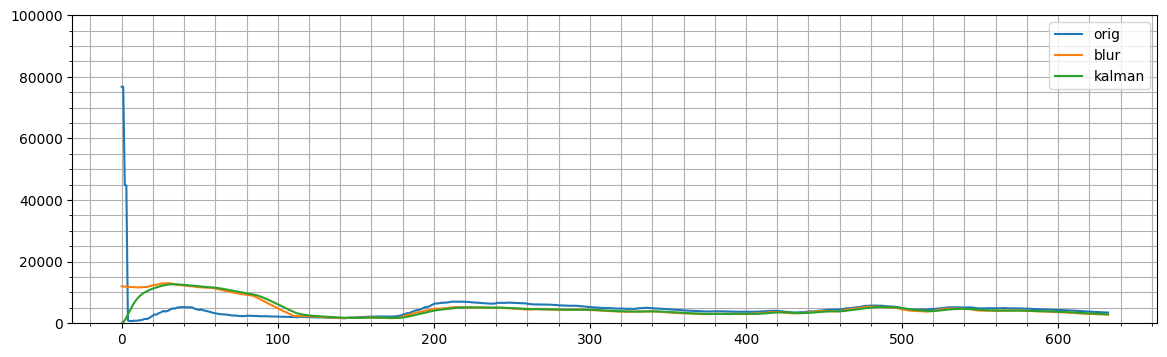

In [12]:
df = pd.DataFrame({
    'orig': filters['original']['signal'],
    'blur': filters['blur']['signal'],
    'kalman': filters['kalman']['signal'],
})

ax = df.plot(figsize=(14, 4))
ax.grid(axis='both', which='both')
plt.minorticks_on()
plt.ylim([0, 100000])
plt.show()

Processing video: /kaggle/input/vids-for-motion-detection/Normal_Videos020_x264.mp4
FPS: 30.0
Total frames: 485


100%|██████████| 485/485.0 [00:02<00:00, 209.23it/s]


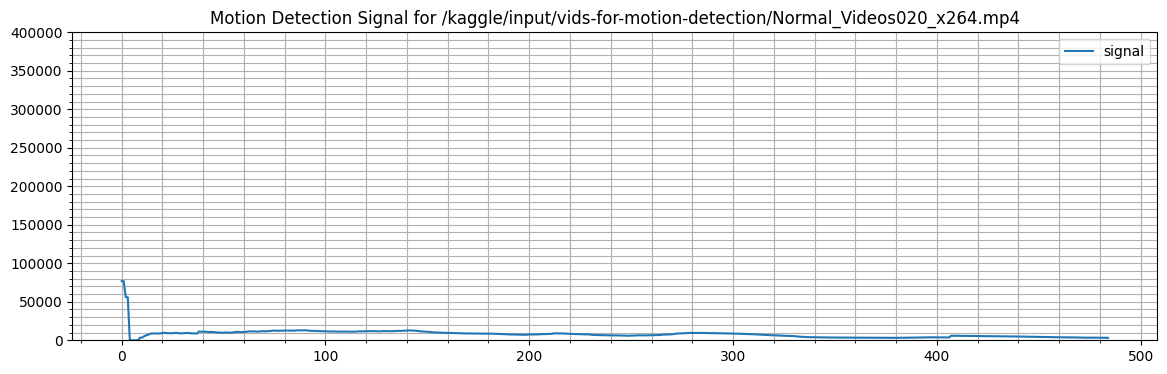

100%|██████████| 485/485.0 [00:02<00:00, 180.30it/s]


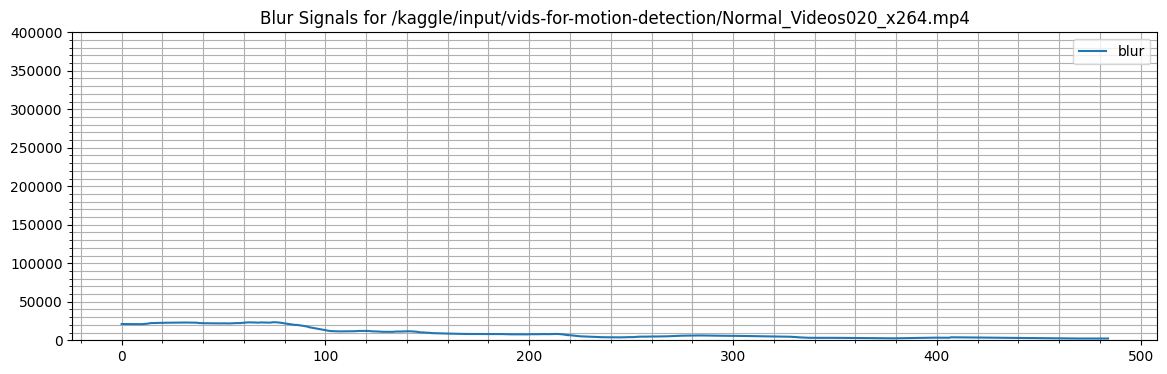

Processing video: /kaggle/input/vids-for-motion-detection/Normal_Videos071_x264.mp4
FPS: 30.0
Total frames: 871


100%|██████████| 871/871.0 [00:03<00:00, 256.36it/s]


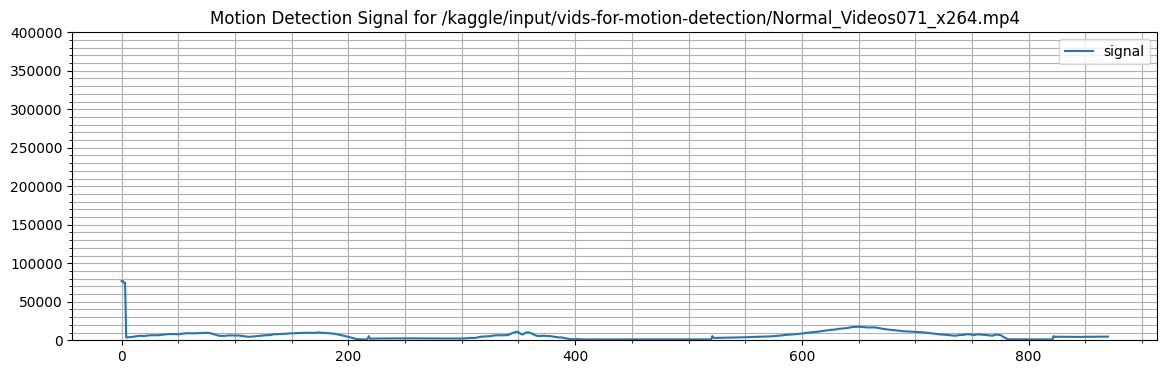

100%|██████████| 871/871.0 [00:04<00:00, 213.25it/s]


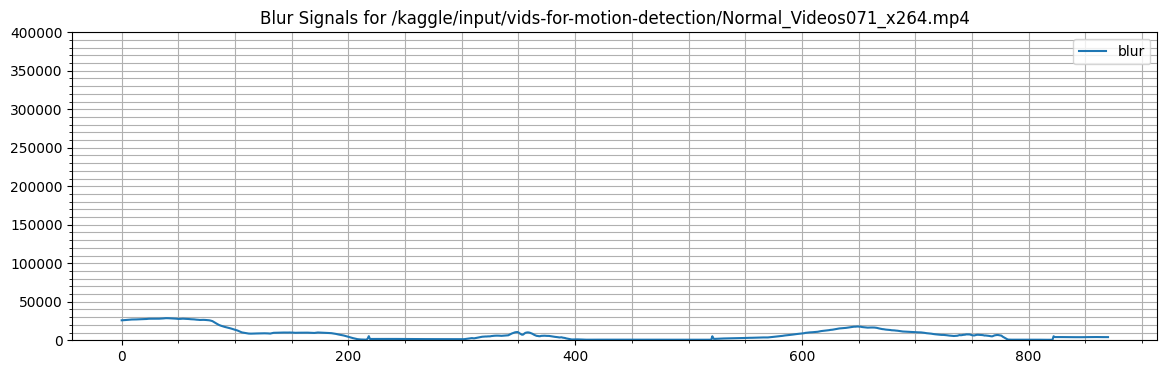

Processing video: /kaggle/input/vids-for-motion-detection/Normal_Videos093_x264.mp4
FPS: 30.0
Total frames: 1740


100%|██████████| 1740/1740.0 [00:03<00:00, 446.92it/s]


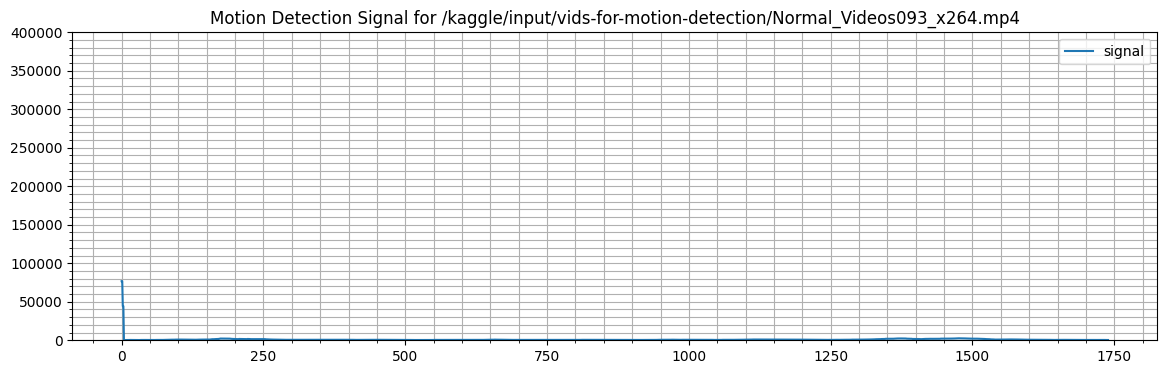

100%|██████████| 1740/1740.0 [00:04<00:00, 378.12it/s]


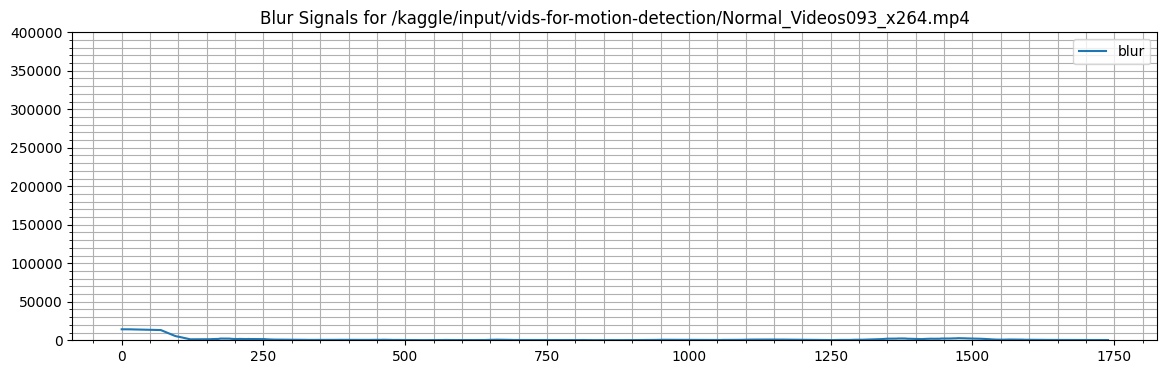

Processing video: /kaggle/input/vids-for-motion-detection/Normal_Videos099_x264.mp4
FPS: 30.0
Total frames: 2075


100%|██████████| 2075/2075.0 [00:04<00:00, 440.65it/s]


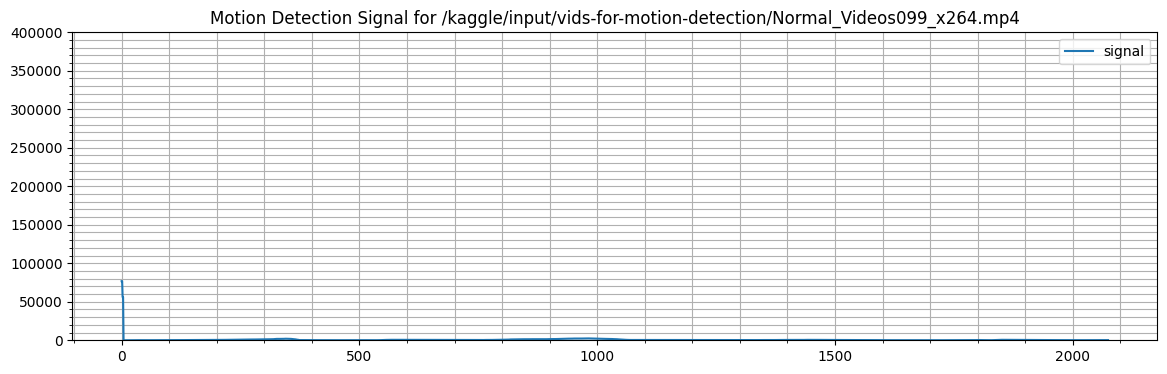

100%|██████████| 2075/2075.0 [00:05<00:00, 405.56it/s]


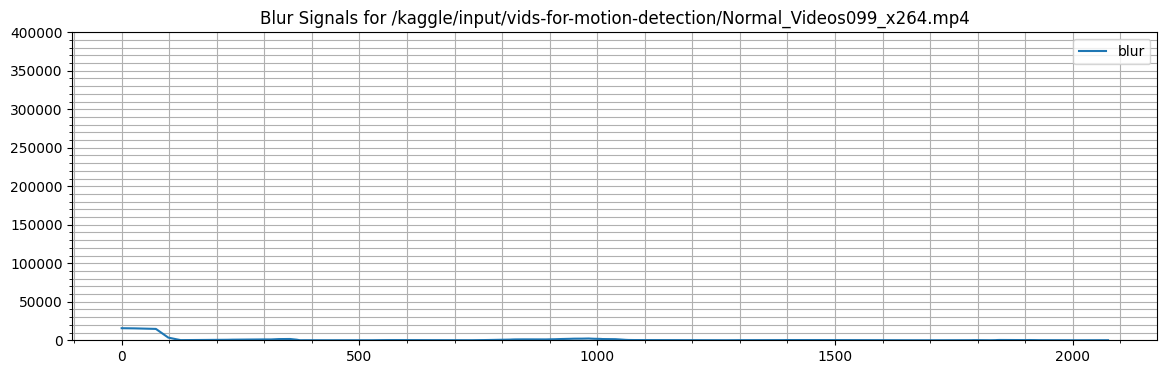

Processing video: /kaggle/input/vids-for-motion-detection/Normal_Videos114_x264.mp4
FPS: 30.0
Total frames: 1787


100%|██████████| 1787/1787.0 [00:04<00:00, 392.96it/s]


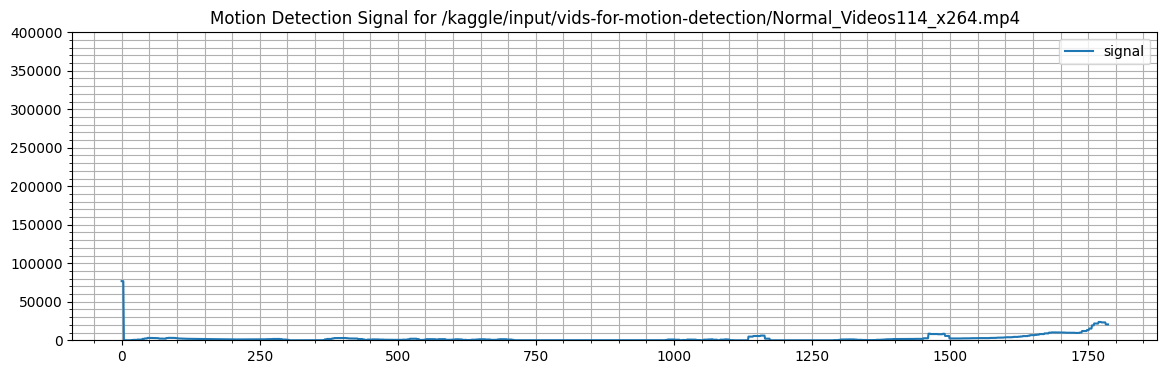

100%|██████████| 1787/1787.0 [00:05<00:00, 338.78it/s]


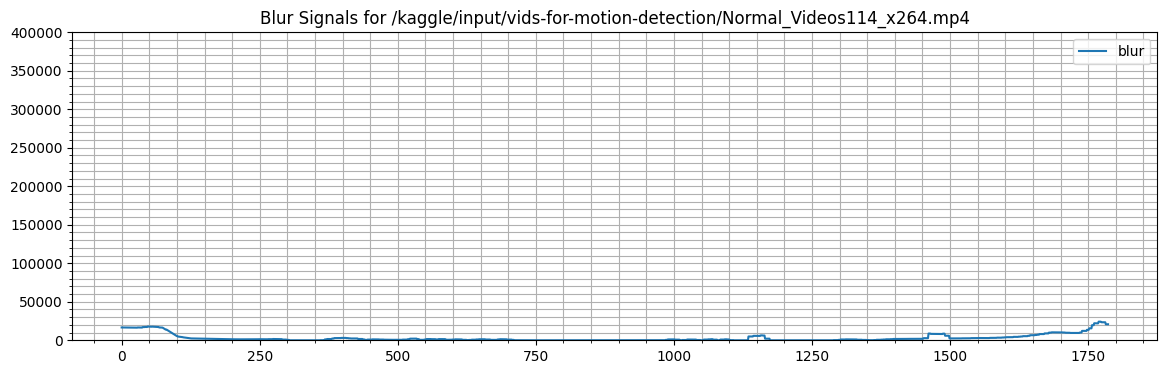

Processing video: /kaggle/input/vids-for-motion-detection/Normal_Videos149_x264.mp4
FPS: 30.0
Total frames: 1021


100%|██████████| 1021/1021.0 [00:04<00:00, 216.91it/s]


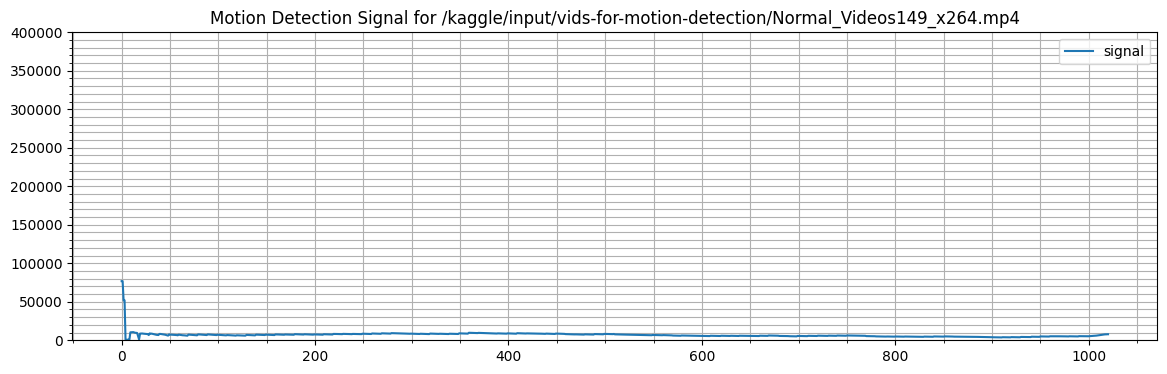

100%|██████████| 1021/1021.0 [00:05<00:00, 185.93it/s]


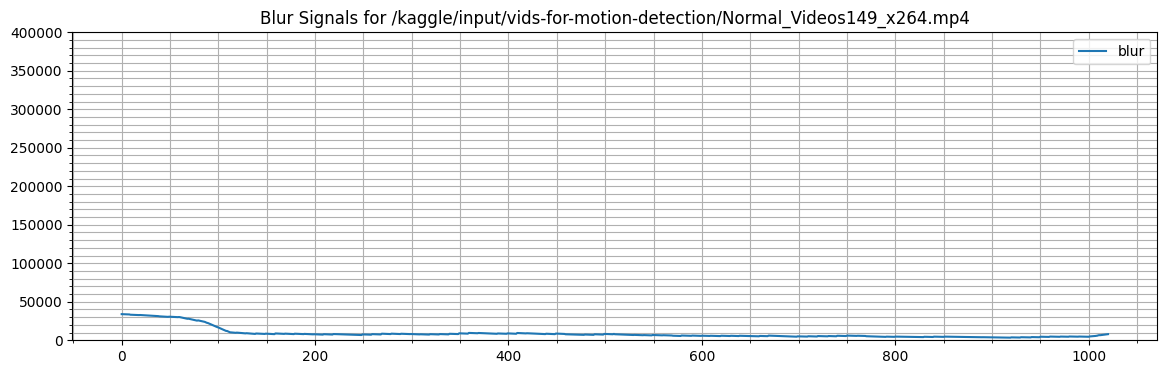

Processing video: /kaggle/input/vids-for-motion-detection/Normal_Videos162_x264.mp4
FPS: 30.0
Total frames: 1169


100%|██████████| 1169/1169.0 [00:03<00:00, 343.93it/s]


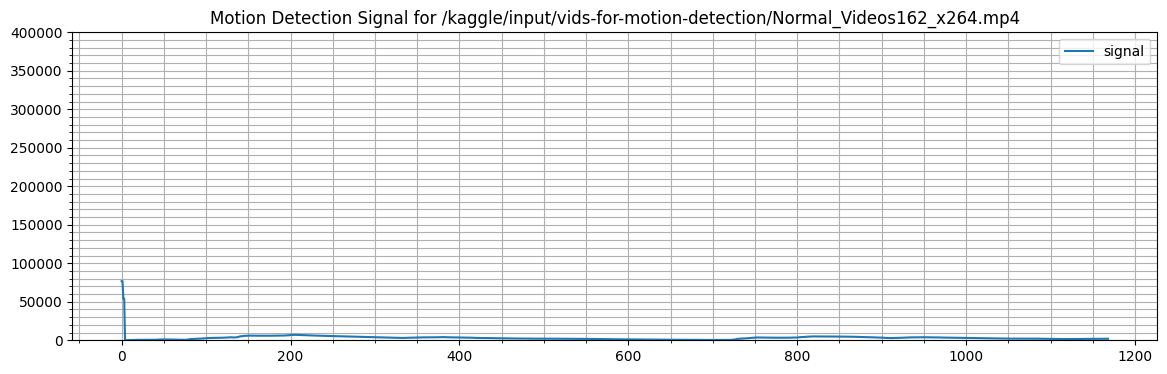

100%|██████████| 1169/1169.0 [00:03<00:00, 299.05it/s]


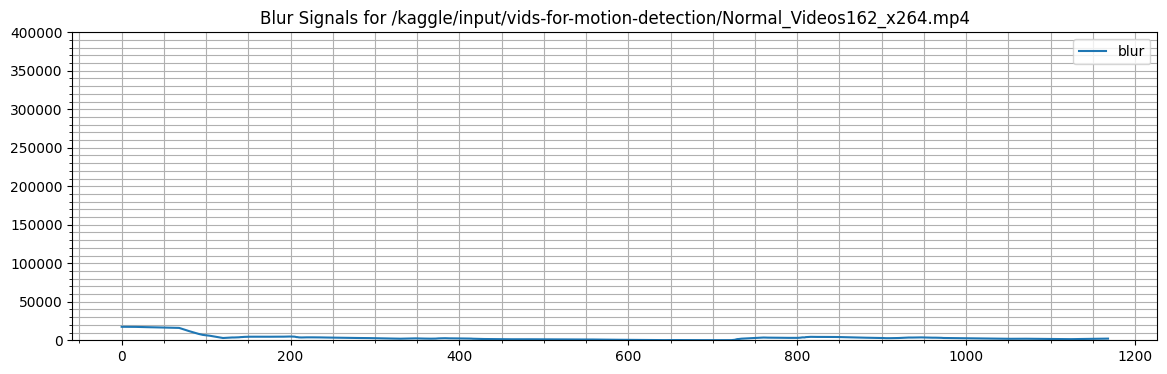

Processing video: /kaggle/input/vids-for-motion-detection/Normal_Videos178_x264.mp4
FPS: 30.0
Total frames: 1028


100%|██████████| 1028/1028.0 [00:03<00:00, 331.01it/s]


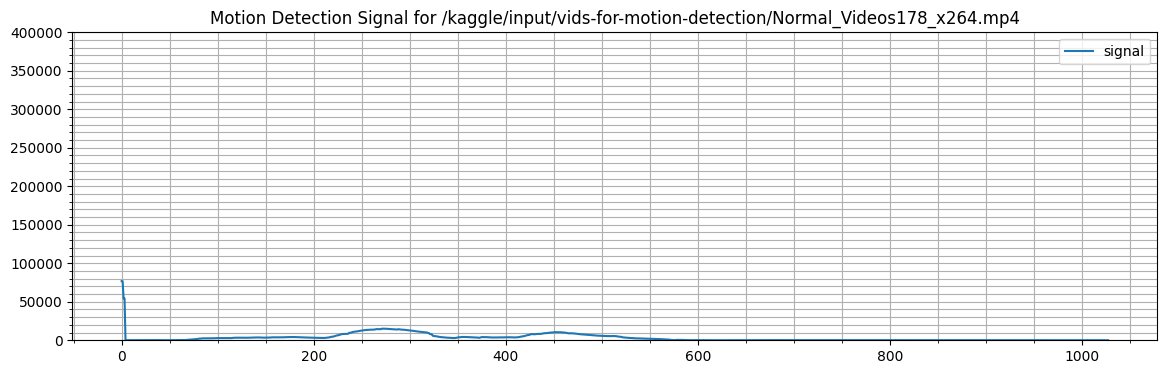

100%|██████████| 1028/1028.0 [00:03<00:00, 296.59it/s]


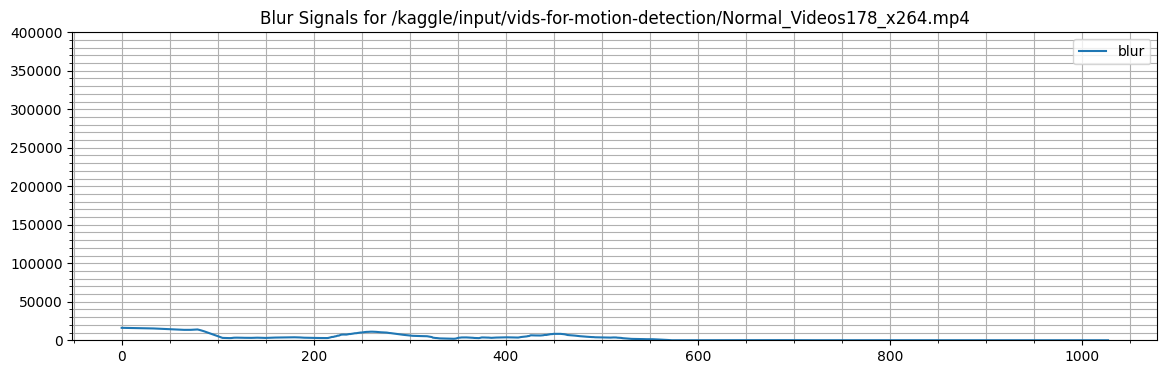

Processing video: /kaggle/input/vids-for-motion-detection/Normal_Videos209_x264.mp4
FPS: 30.0
Total frames: 633


100%|██████████| 633/633.0 [00:02<00:00, 292.89it/s]


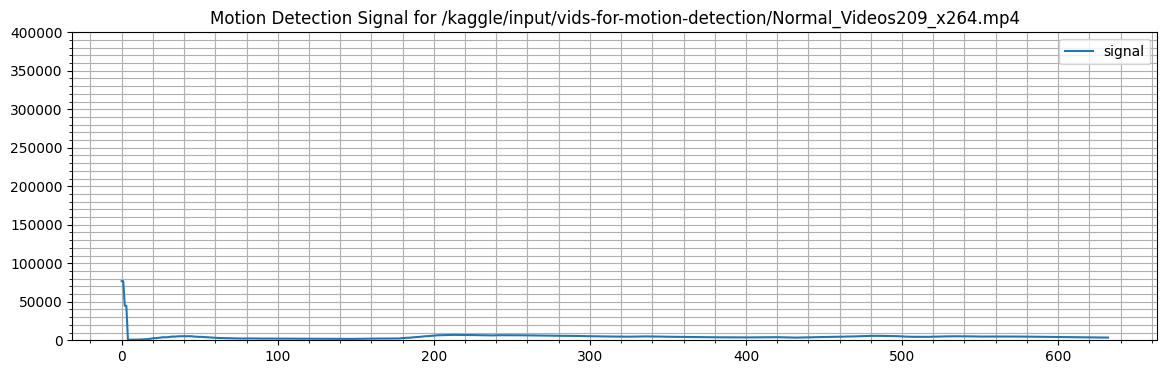

100%|██████████| 633/633.0 [00:02<00:00, 239.37it/s]


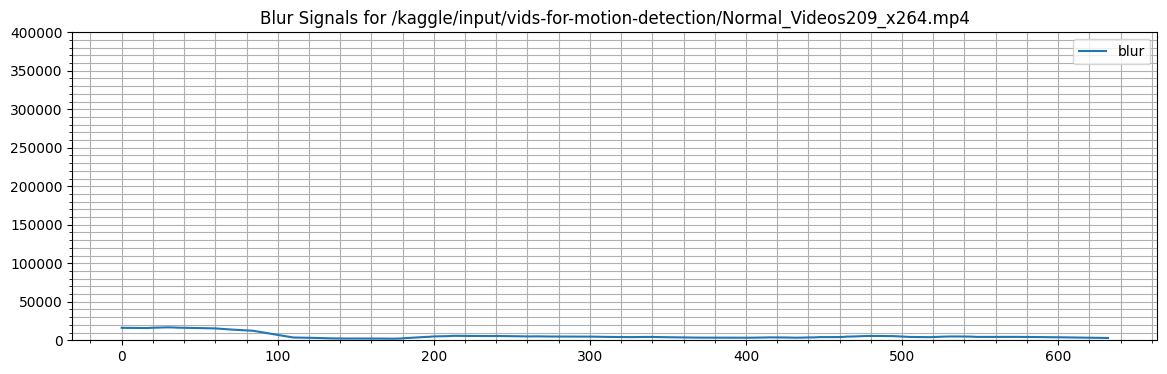

Processing video: /kaggle/input/vids-for-motion-detection/Normal_Videos222_x264.mp4
FPS: 30.0
Total frames: 949


100%|██████████| 949/949.0 [00:04<00:00, 213.68it/s]


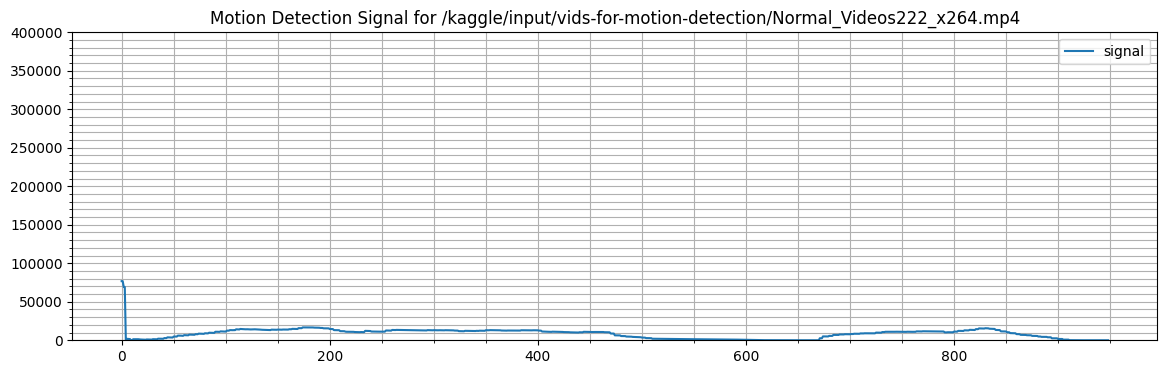

100%|██████████| 949/949.0 [00:04<00:00, 202.19it/s]


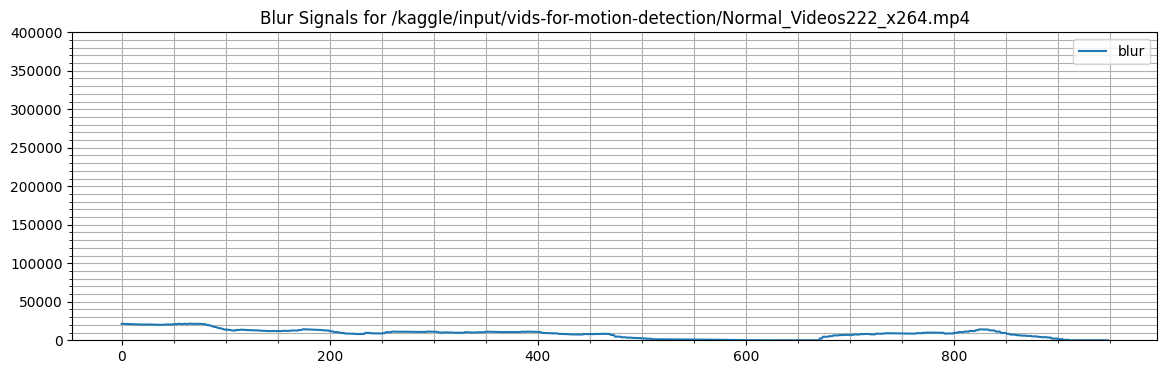

Processing video: /kaggle/input/vids-for-motion-detection/Normal_Videos236_x264.mp4
FPS: 30.0
Total frames: 3380


100%|██████████| 3380/3380.0 [00:07<00:00, 441.39it/s]


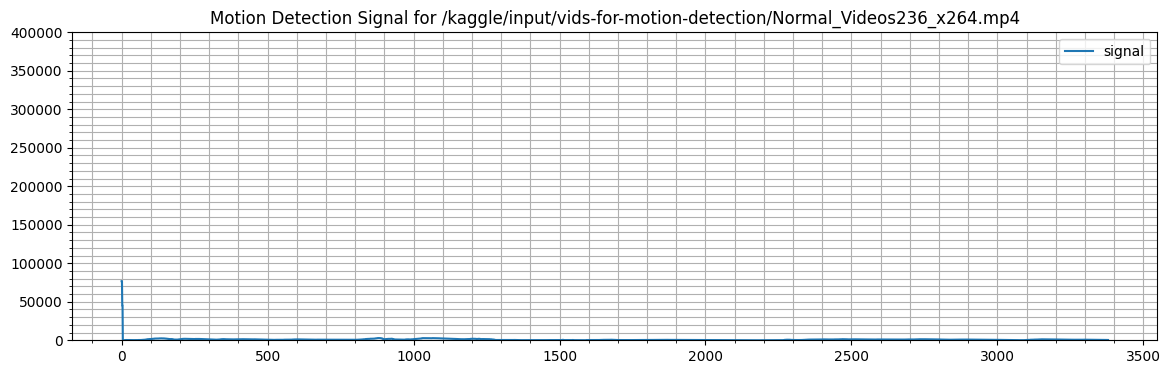

100%|██████████| 3380/3380.0 [00:08<00:00, 395.14it/s]


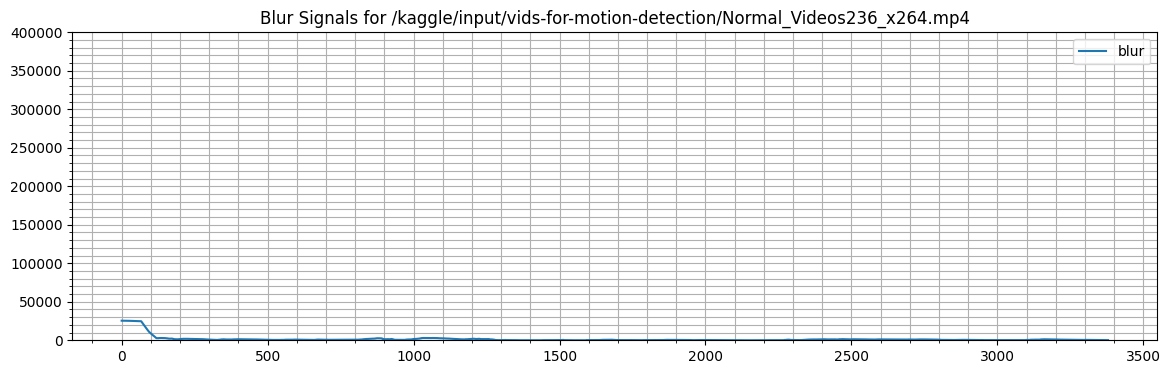

Processing video: /kaggle/input/vids-for-motion-detection/Normal_Videos243_x264.mp4
FPS: 30.0
Total frames: 1827


100%|██████████| 1827/1827.0 [00:04<00:00, 380.02it/s]


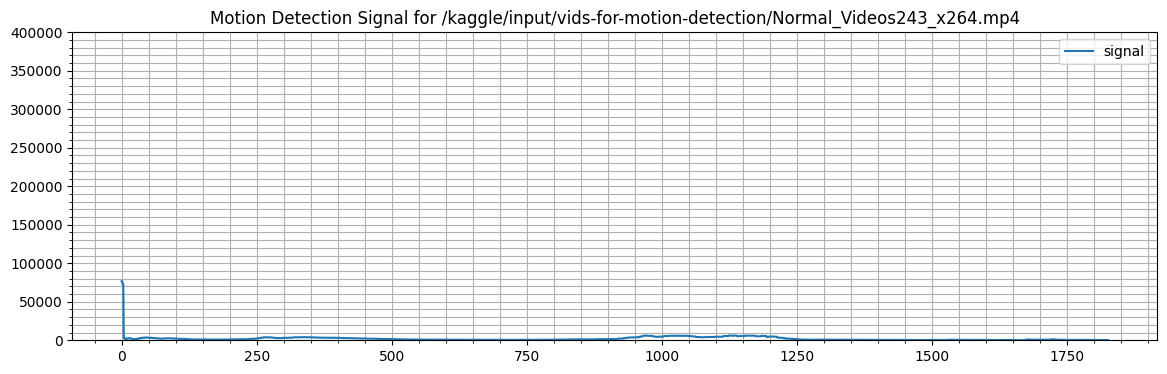

100%|██████████| 1827/1827.0 [00:05<00:00, 333.56it/s]


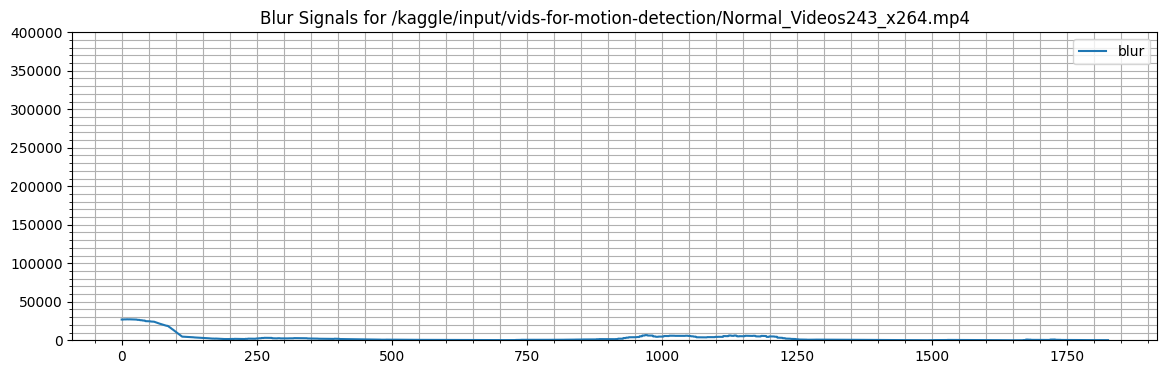

Processing video: /kaggle/input/vids-for-motion-detection/Normal_Videos244_x264.mp4
FPS: 30.0
Total frames: 2756


100%|██████████| 2756/2756.0 [00:06<00:00, 424.79it/s]


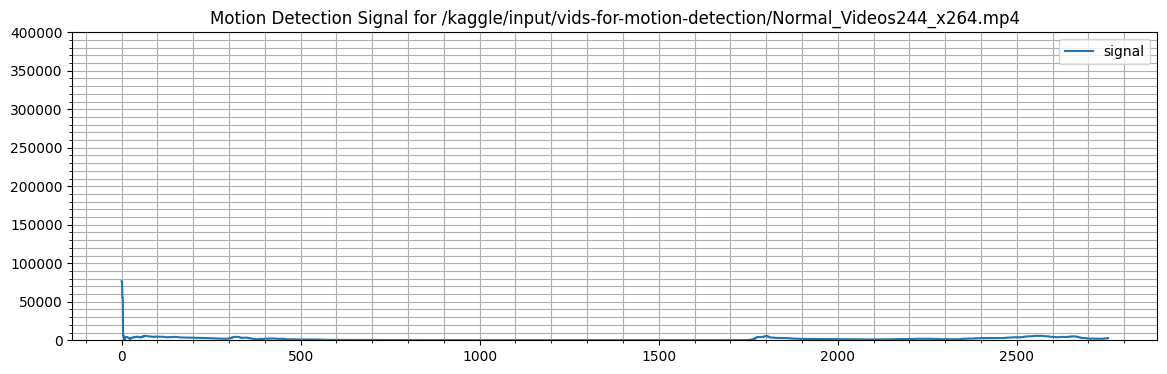

100%|██████████| 2756/2756.0 [00:07<00:00, 379.12it/s]


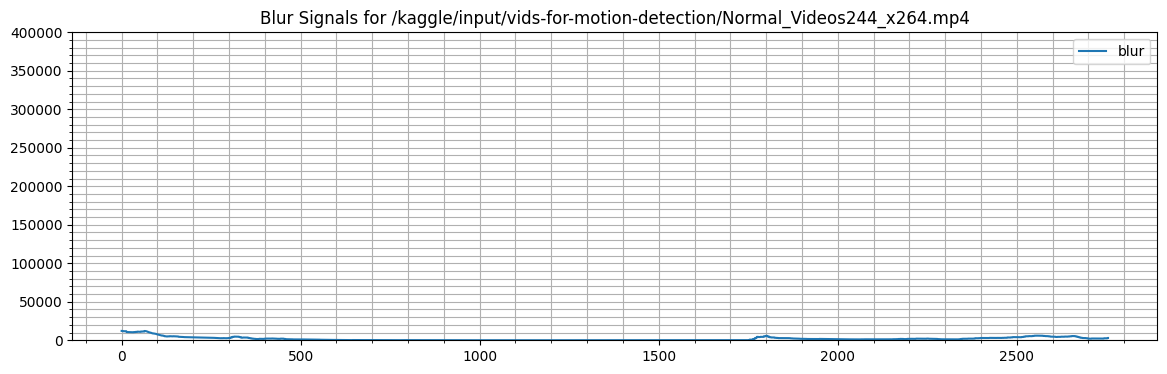

In [13]:
import cv2 as cv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

def process_video(video_file):
    capture = cv.VideoCapture(video_file)
    print(f'Processing video: {video_file}')
    print(f'FPS: {capture.get(cv.CAP_PROP_FPS)}')
    print(f'Total frames: {int(capture.get(cv.CAP_PROP_FRAME_COUNT))}')
    
    backSub = cv.createBackgroundSubtractorKNN()
    
    masks = []
    
    # First pass: Get motion detection signals
    with tqdm(total=capture.get(cv.CAP_PROP_FRAME_COUNT)) as pbar:
        while True:
            ret, frame = capture.read()
            if not ret:  # Check if frame is valid
                break
            pbar.update(1)
            fgMask = backSub.apply(frame)
            masks.append(fgMask[fgMask > 0].shape[0])
    
    df = pd.DataFrame({'signal': masks})
    ax = df.plot(figsize=(14, 4))
    ax.grid(axis='both', which='both')
    plt.minorticks_on()
    plt.ylim([0, 400000])
    plt.title(f'Motion Detection Signal for {video_file}')
    plt.show()

    # Kalman Filter setup
    kalman_arr = []
    kalman = cv.KalmanFilter(2, 1)
    kalman.measurementMatrix = np.array([[1, 0]], np.float32)
    kalman.transitionMatrix = np.array([[1, 0], [0, 1]], np.float32)
    kalman.processNoiseCov = np.array([[1, 0], [0, 1]], np.float32) * 0.03

    # Filtering section with only blur and Kalman
    filters = {
        'blur': {'filter': lambda x: cv.blur(x, (5, 5)), 'subtractor': backSub, 'signal': []},
        'kalman': {'filter': None, 'subtractor': None, 'signal': []},
    }

    # Reset the capture to start again
    capture.set(cv.CAP_PROP_POS_FRAMES, 0)

    # Second pass: Apply filters and get signals
    with tqdm(total=capture.get(cv.CAP_PROP_FRAME_COUNT)) as pbar:
        while True:
            ret, frame = capture.read()
            if not ret:  # Check if frame is valid
                break
            pbar.update(1)

            # Apply blur filter
            filtered_frame = filters['blur']['filter'](frame)
            mask = filters['blur']['subtractor'].apply(filtered_frame)
            filters['blur']['signal'].append(mask[mask > 0].shape[0])

            # Kalman filter prediction
#             measurement = np.array([np.float32(mask[mask > 0].shape[0])])
#             kalman.correct(measurement)
#             prediction = kalman.predict()
#             filters['kalman']['signal'].append(prediction[0][0])

    df = pd.DataFrame({
        'blur': filters['blur']['signal'],
#         'kalman': filters['kalman']['signal'],
    })

    ax = df.plot(figsize=(14, 4))
    ax.grid(axis='both', which='both')
    plt.minorticks_on()
    plt.ylim([0, 400000])
    plt.title(f'Blur Signals for {video_file}')
    plt.show()

# List of video files
video_files = [
    '/kaggle/input/vids-for-motion-detection/Normal_Videos020_x264.mp4',
    '/kaggle/input/vids-for-motion-detection/Normal_Videos071_x264.mp4',
    '/kaggle/input/vids-for-motion-detection/Normal_Videos093_x264.mp4',
    '/kaggle/input/vids-for-motion-detection/Normal_Videos099_x264.mp4',
    '/kaggle/input/vids-for-motion-detection/Normal_Videos114_x264.mp4',
    '/kaggle/input/vids-for-motion-detection/Normal_Videos149_x264.mp4',
    '/kaggle/input/vids-for-motion-detection/Normal_Videos162_x264.mp4',
    '/kaggle/input/vids-for-motion-detection/Normal_Videos178_x264.mp4',
    '/kaggle/input/vids-for-motion-detection/Normal_Videos209_x264.mp4',
    '/kaggle/input/vids-for-motion-detection/Normal_Videos222_x264.mp4',
    '/kaggle/input/vids-for-motion-detection/Normal_Videos236_x264.mp4',
    '/kaggle/input/vids-for-motion-detection/Normal_Videos243_x264.mp4',
    '/kaggle/input/vids-for-motion-detection/Normal_Videos244_x264.mp4',
]

# Loop through all video files
for video_file in video_files:
    process_video(video_file)

Processing video: /kaggle/input/vids-for-motion-detection/Normal_Videos020_x264.mp4
FPS: 30.0
Total frames: 485


100%|██████████| 485/485.0 [00:02<00:00, 210.13it/s]


Raw SNR for /kaggle/input/vids-for-motion-detection/Normal_Videos020_x264.mp4: 1.09 dB


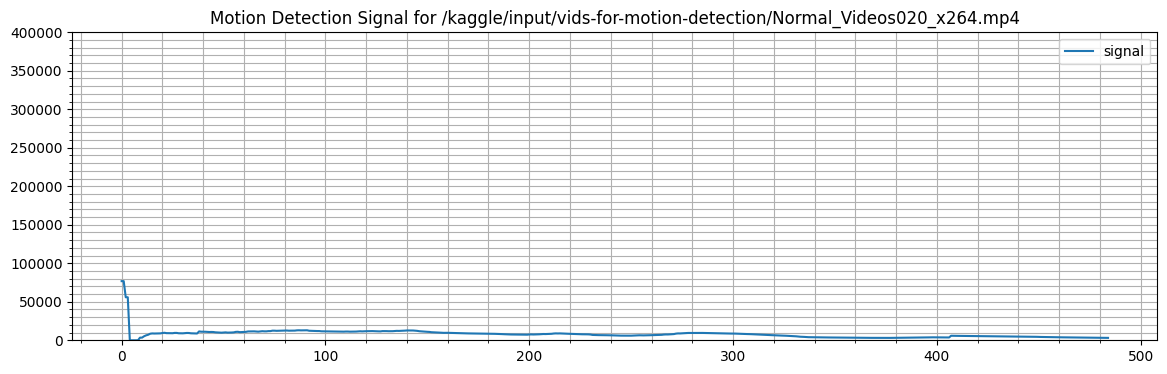

100%|██████████| 485/485.0 [00:02<00:00, 183.02it/s]


Blurred SNR for /kaggle/input/vids-for-motion-detection/Normal_Videos020_x264.mp4: 1.05 dB

SNR Comparison Table:
        Metric  Value (dB)
0      Raw SNR    1.086764
1  Blurred SNR    1.047217


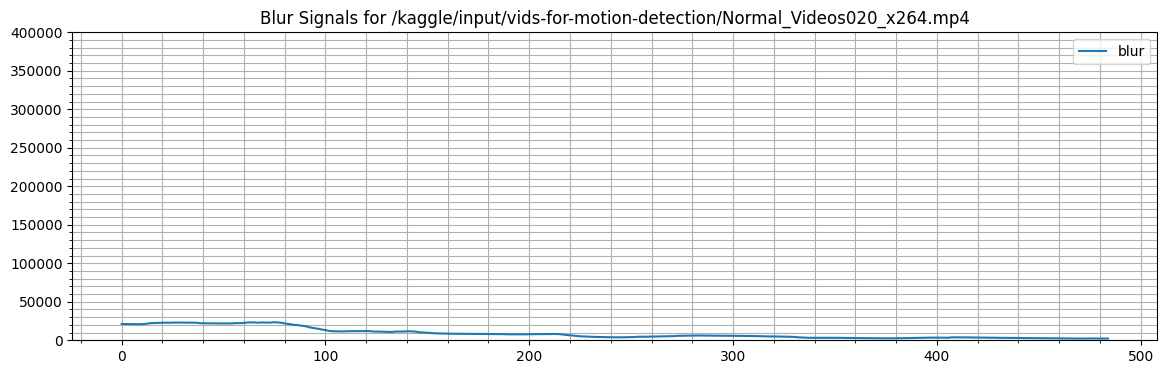

Processing video: /kaggle/input/vids-for-motion-detection/Normal_Videos071_x264.mp4
FPS: 30.0
Total frames: 871


100%|██████████| 871/871.0 [00:03<00:00, 251.36it/s]


Raw SNR for /kaggle/input/vids-for-motion-detection/Normal_Videos071_x264.mp4: -0.05 dB


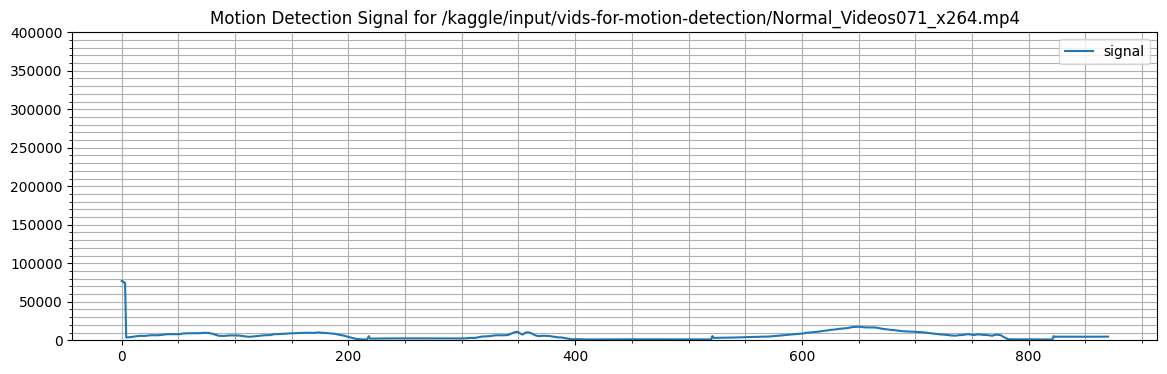

100%|██████████| 871/871.0 [00:04<00:00, 214.88it/s]


Blurred SNR for /kaggle/input/vids-for-motion-detection/Normal_Videos071_x264.mp4: -0.00 dB

SNR Comparison Table:
        Metric  Value (dB)
0      Raw SNR   -0.053369
1  Blurred SNR   -0.001850


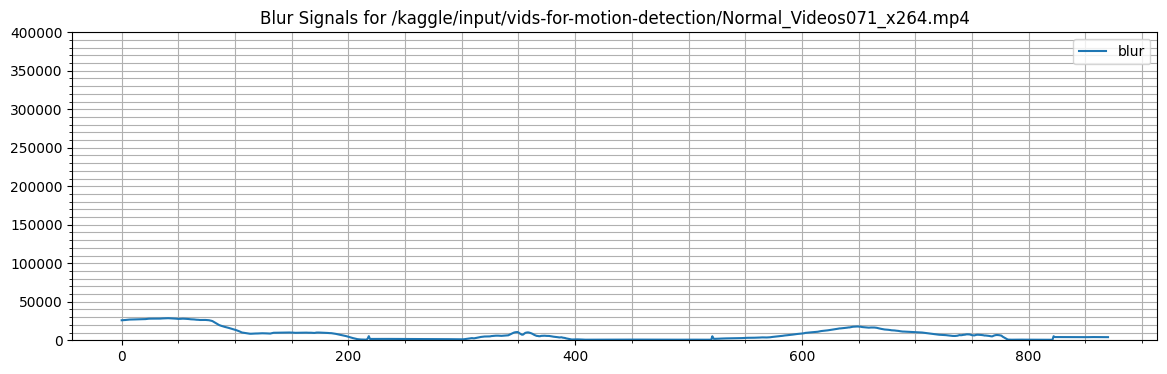

Processing video: /kaggle/input/vids-for-motion-detection/Normal_Videos093_x264.mp4
FPS: 30.0
Total frames: 1740


100%|██████████| 1740/1740.0 [00:03<00:00, 444.68it/s]


Raw SNR for /kaggle/input/vids-for-motion-detection/Normal_Videos093_x264.mp4: -4.95 dB


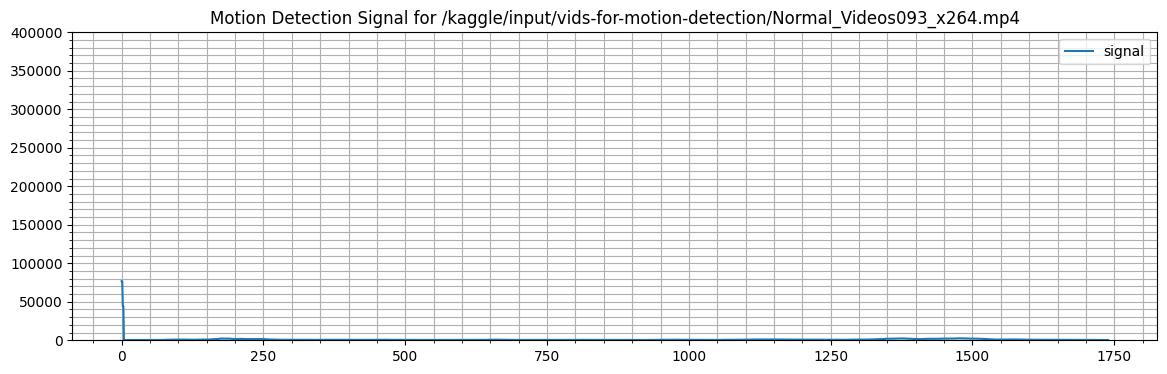

100%|██████████| 1740/1740.0 [00:04<00:00, 382.86it/s]


Blurred SNR for /kaggle/input/vids-for-motion-detection/Normal_Videos093_x264.mp4: -2.80 dB

SNR Comparison Table:
        Metric  Value (dB)
0      Raw SNR   -4.946554
1  Blurred SNR   -2.797103


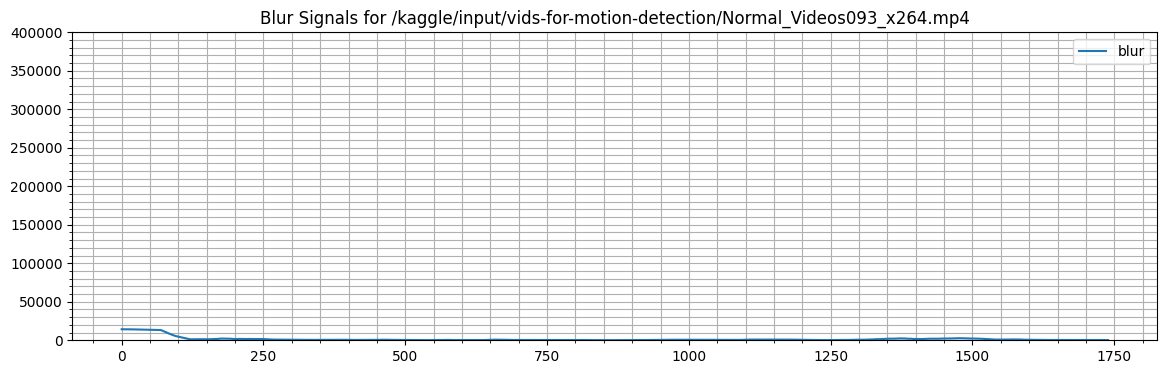

Processing video: /kaggle/input/vids-for-motion-detection/Normal_Videos099_x264.mp4
FPS: 30.0
Total frames: 2075


100%|██████████| 2075/2075.0 [00:04<00:00, 472.36it/s]


Raw SNR for /kaggle/input/vids-for-motion-detection/Normal_Videos099_x264.mp4: -6.60 dB


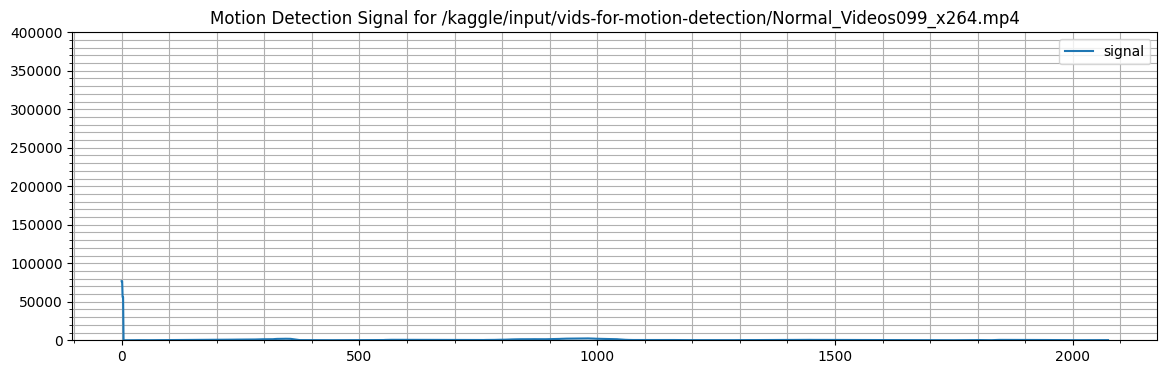

100%|██████████| 2075/2075.0 [00:05<00:00, 407.30it/s]


Blurred SNR for /kaggle/input/vids-for-motion-detection/Normal_Videos099_x264.mp4: -4.47 dB

SNR Comparison Table:
        Metric  Value (dB)
0      Raw SNR   -6.603920
1  Blurred SNR   -4.467346


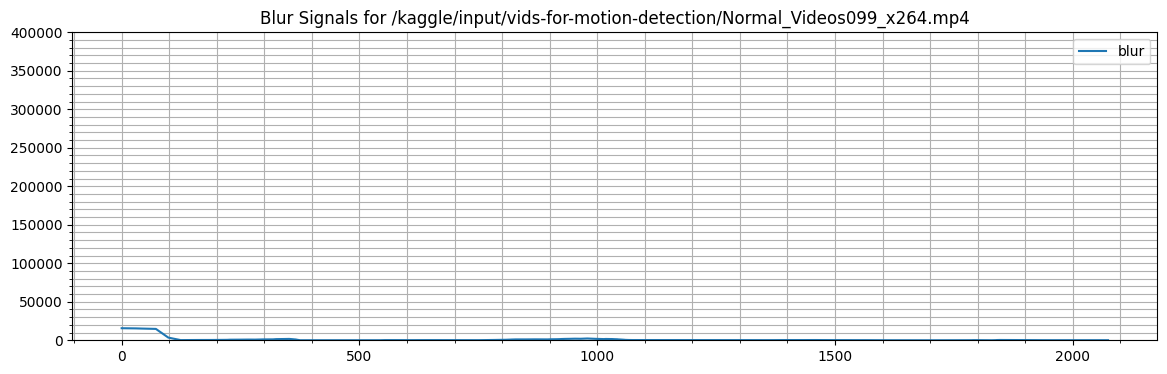

Processing video: /kaggle/input/vids-for-motion-detection/Normal_Videos114_x264.mp4
FPS: 30.0
Total frames: 1787


100%|██████████| 1787/1787.0 [00:04<00:00, 400.44it/s]


Raw SNR for /kaggle/input/vids-for-motion-detection/Normal_Videos114_x264.mp4: -3.35 dB


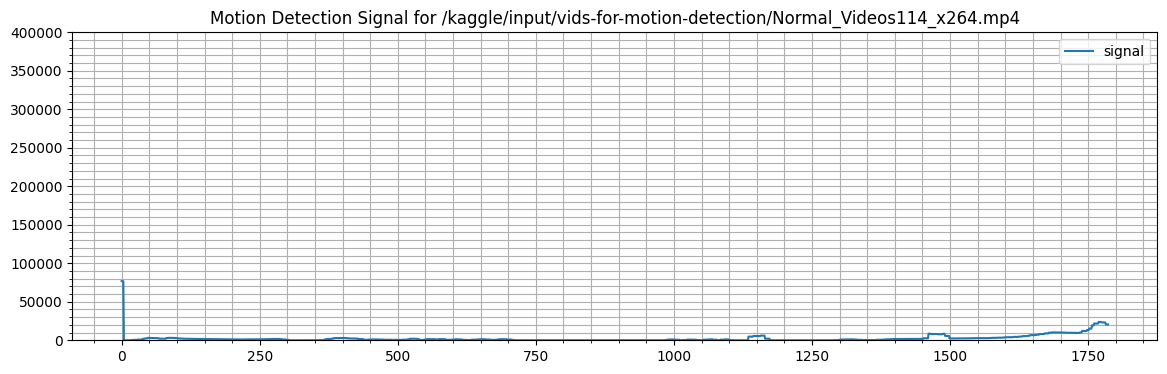

100%|██████████| 1787/1787.0 [00:05<00:00, 341.10it/s]


Blurred SNR for /kaggle/input/vids-for-motion-detection/Normal_Videos114_x264.mp4: -2.04 dB

SNR Comparison Table:
        Metric  Value (dB)
0      Raw SNR   -3.351397
1  Blurred SNR   -2.042366


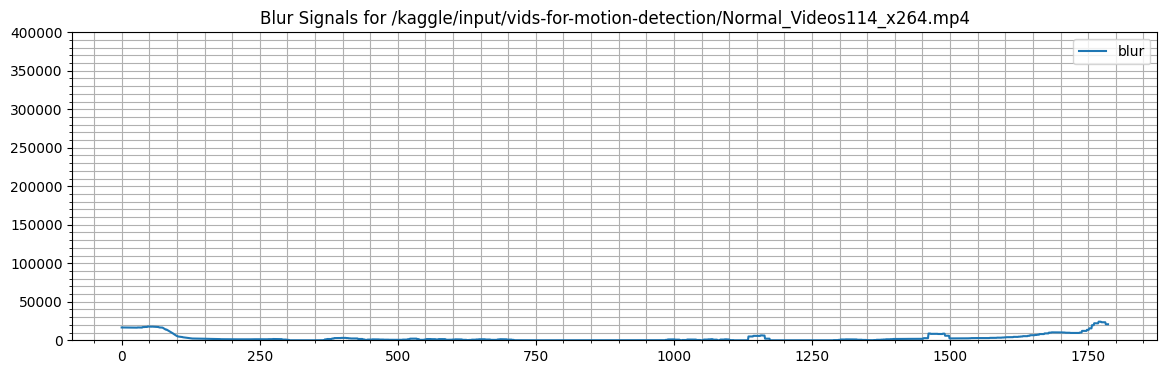

Processing video: /kaggle/input/vids-for-motion-detection/Normal_Videos149_x264.mp4
FPS: 30.0
Total frames: 1021


100%|██████████| 1021/1021.0 [00:04<00:00, 222.24it/s]


Raw SNR for /kaggle/input/vids-for-motion-detection/Normal_Videos149_x264.mp4: 2.34 dB


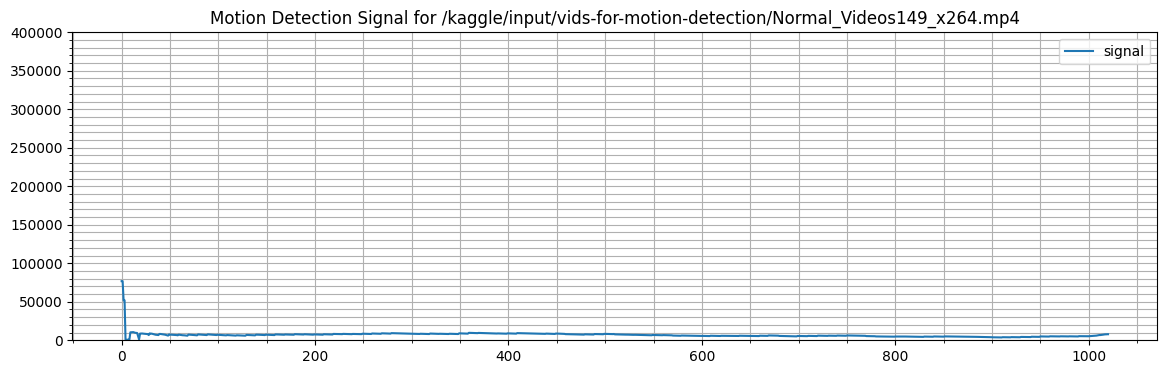

100%|██████████| 1021/1021.0 [00:05<00:00, 188.15it/s]


Blurred SNR for /kaggle/input/vids-for-motion-detection/Normal_Videos149_x264.mp4: 0.96 dB

SNR Comparison Table:
        Metric  Value (dB)
0      Raw SNR    2.340362
1  Blurred SNR    0.955371


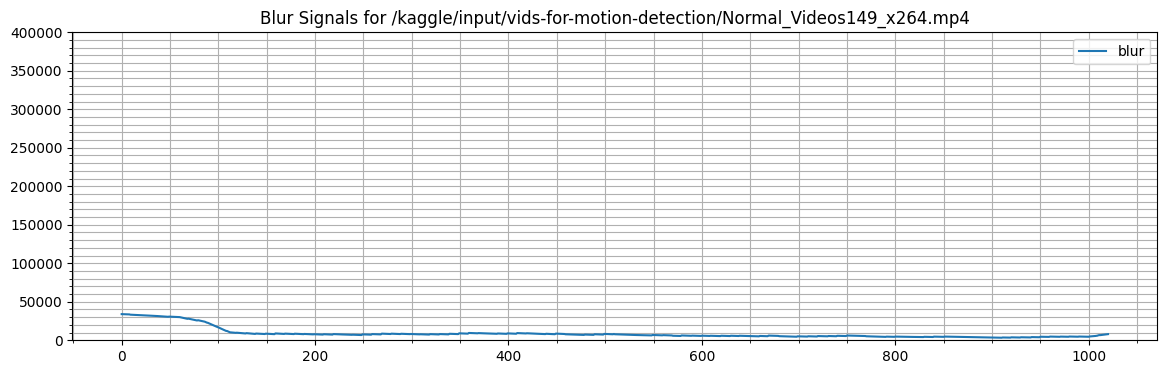

Processing video: /kaggle/input/vids-for-motion-detection/Normal_Videos162_x264.mp4
FPS: 30.0
Total frames: 1169


100%|██████████| 1169/1169.0 [00:03<00:00, 342.92it/s]


Raw SNR for /kaggle/input/vids-for-motion-detection/Normal_Videos162_x264.mp4: -1.13 dB


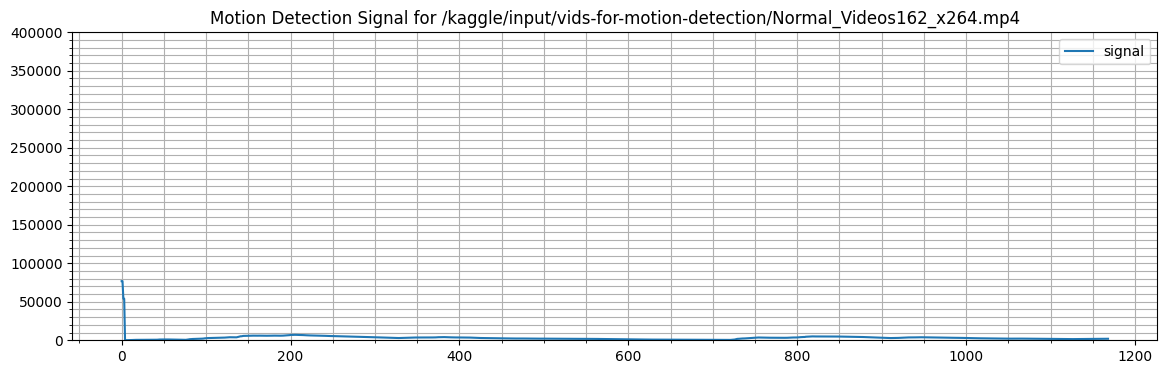

100%|██████████| 1169/1169.0 [00:03<00:00, 302.60it/s]


Blurred SNR for /kaggle/input/vids-for-motion-detection/Normal_Videos162_x264.mp4: -0.47 dB

SNR Comparison Table:
        Metric  Value (dB)
0      Raw SNR   -1.126489
1  Blurred SNR   -0.472008


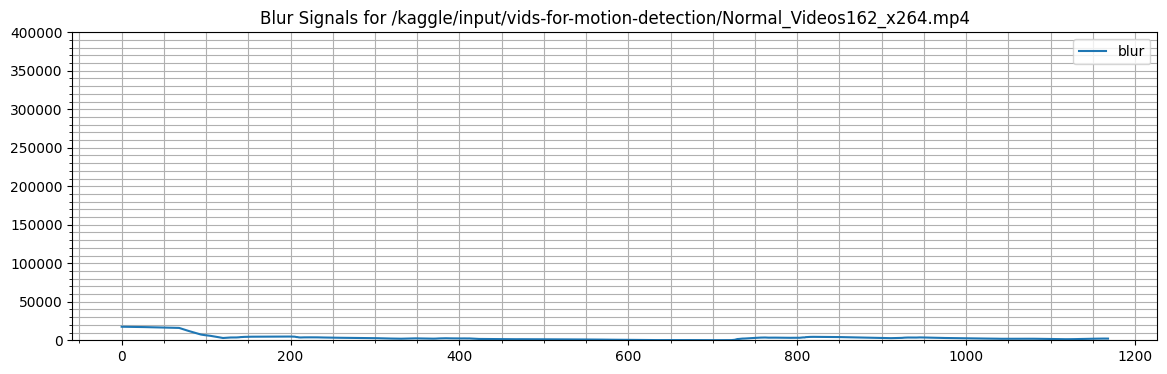

Processing video: /kaggle/input/vids-for-motion-detection/Normal_Videos178_x264.mp4
FPS: 30.0
Total frames: 1028


100%|██████████| 1028/1028.0 [00:03<00:00, 333.33it/s]


Raw SNR for /kaggle/input/vids-for-motion-detection/Normal_Videos178_x264.mp4: -2.40 dB


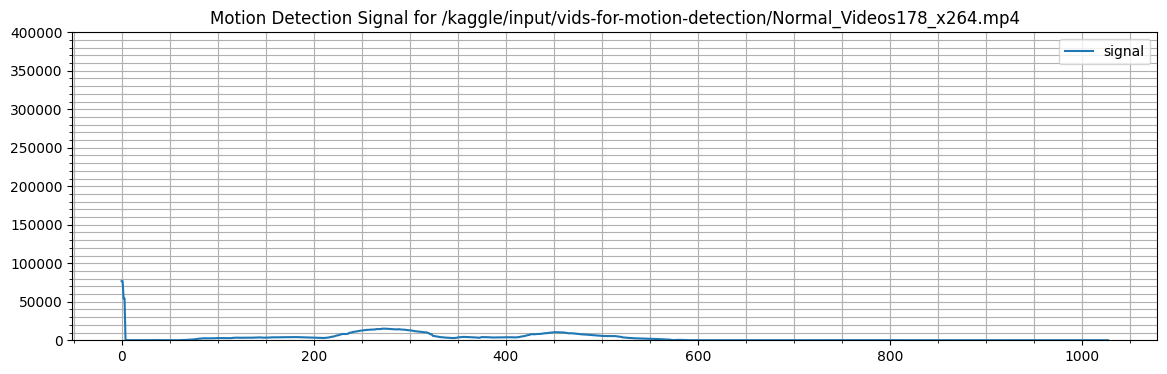

100%|██████████| 1028/1028.0 [00:03<00:00, 299.82it/s]


Blurred SNR for /kaggle/input/vids-for-motion-detection/Normal_Videos178_x264.mp4: -1.06 dB

SNR Comparison Table:
        Metric  Value (dB)
0      Raw SNR   -2.401812
1  Blurred SNR   -1.058670


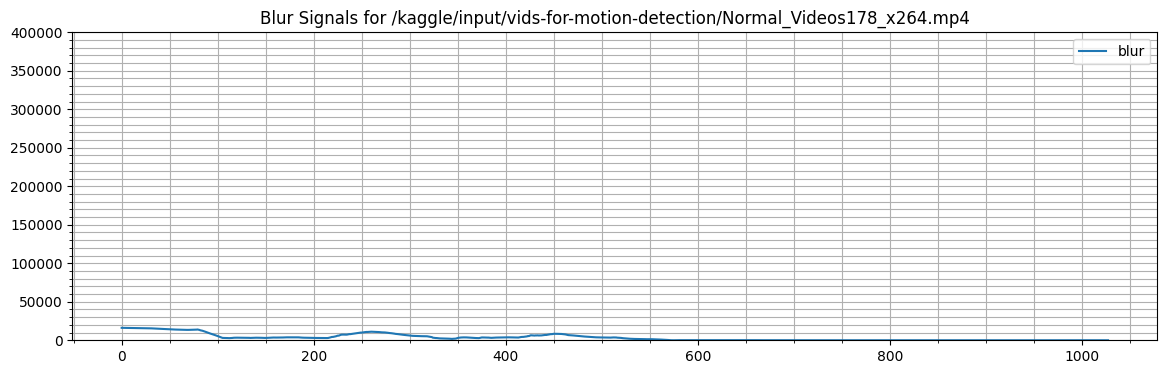

Processing video: /kaggle/input/vids-for-motion-detection/Normal_Videos209_x264.mp4
FPS: 30.0
Total frames: 633


100%|██████████| 633/633.0 [00:02<00:00, 290.92it/s]


Raw SNR for /kaggle/input/vids-for-motion-detection/Normal_Videos209_x264.mp4: -0.26 dB


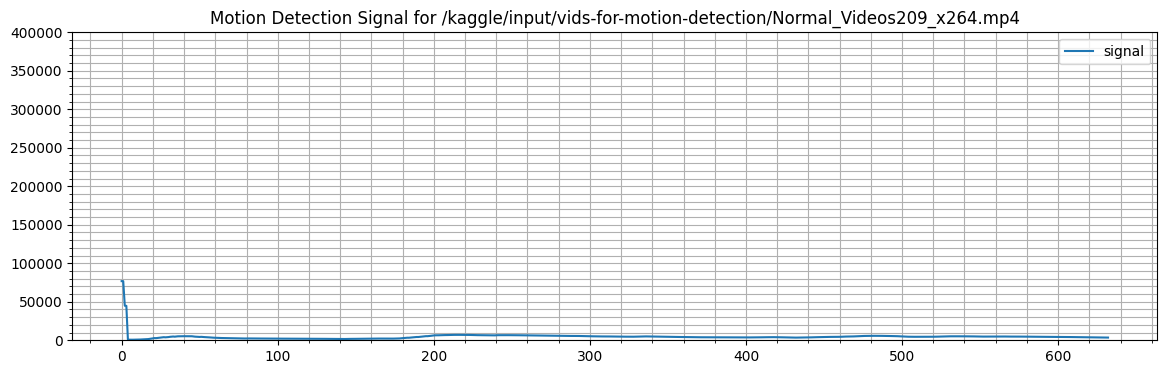

100%|██████████| 633/633.0 [00:02<00:00, 236.46it/s]


Blurred SNR for /kaggle/input/vids-for-motion-detection/Normal_Videos209_x264.mp4: 1.58 dB

SNR Comparison Table:
        Metric  Value (dB)
0      Raw SNR   -0.258296
1  Blurred SNR    1.584635


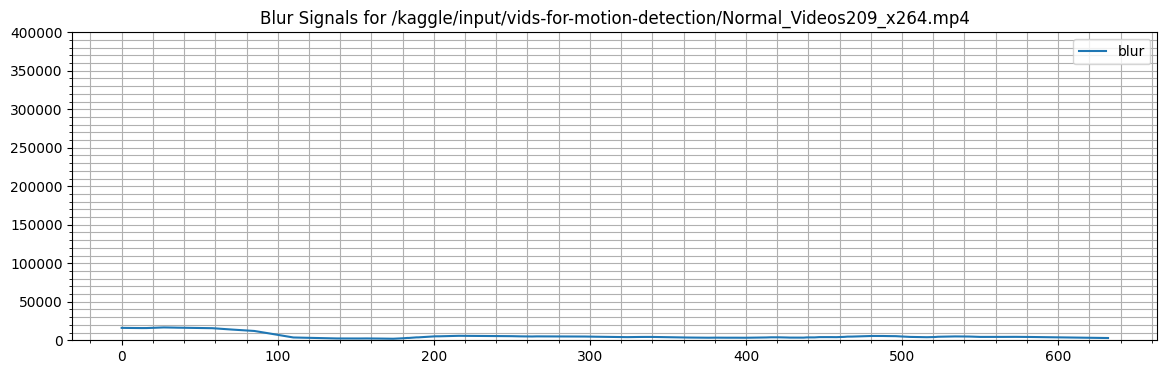

Processing video: /kaggle/input/vids-for-motion-detection/Normal_Videos222_x264.mp4
FPS: 30.0
Total frames: 949


100%|██████████| 949/949.0 [00:04<00:00, 225.03it/s]


Raw SNR for /kaggle/input/vids-for-motion-detection/Normal_Videos222_x264.mp4: 1.01 dB


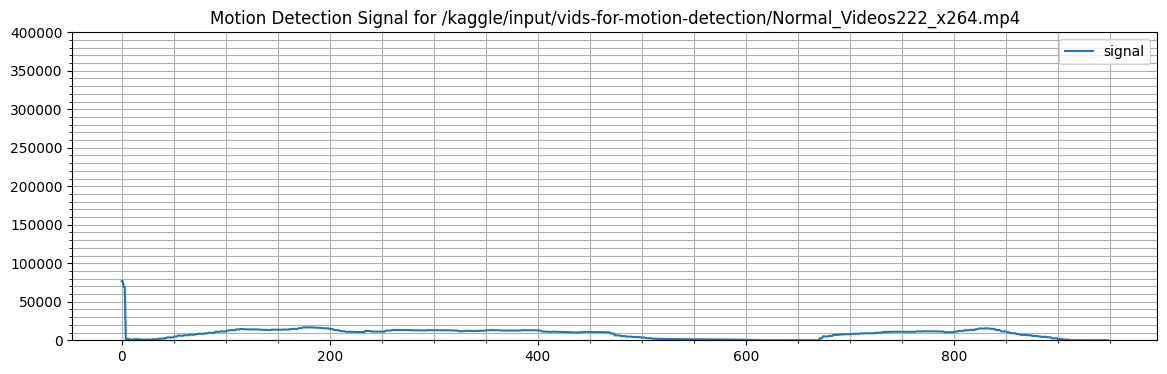

100%|██████████| 949/949.0 [00:04<00:00, 197.73it/s]


Blurred SNR for /kaggle/input/vids-for-motion-detection/Normal_Videos222_x264.mp4: 1.58 dB

SNR Comparison Table:
        Metric  Value (dB)
0      Raw SNR    1.014878
1  Blurred SNR    1.581872


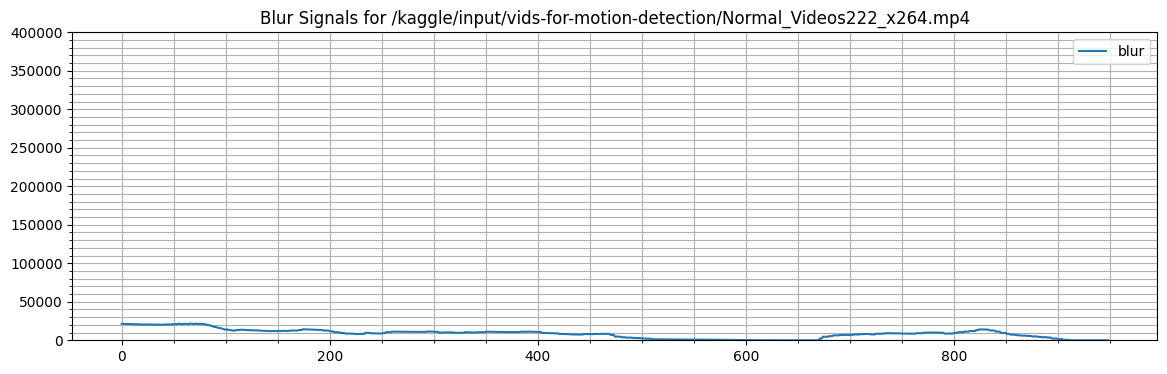

Processing video: /kaggle/input/vids-for-motion-detection/Normal_Videos236_x264.mp4
FPS: 30.0
Total frames: 3380


100%|██████████| 3380/3380.0 [00:07<00:00, 448.15it/s]


Raw SNR for /kaggle/input/vids-for-motion-detection/Normal_Videos236_x264.mp4: -3.78 dB


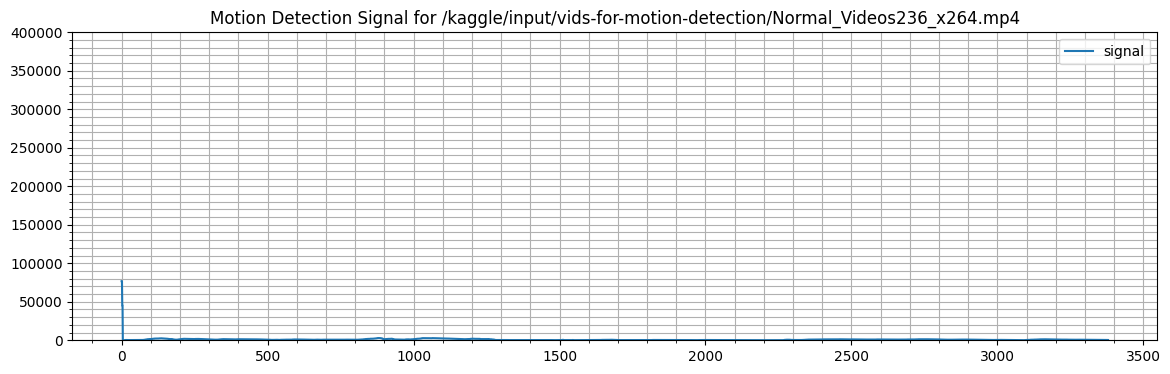

100%|██████████| 3380/3380.0 [00:08<00:00, 382.74it/s]


Blurred SNR for /kaggle/input/vids-for-motion-detection/Normal_Videos236_x264.mp4: -4.19 dB

SNR Comparison Table:
        Metric  Value (dB)
0      Raw SNR   -3.782138
1  Blurred SNR   -4.192846


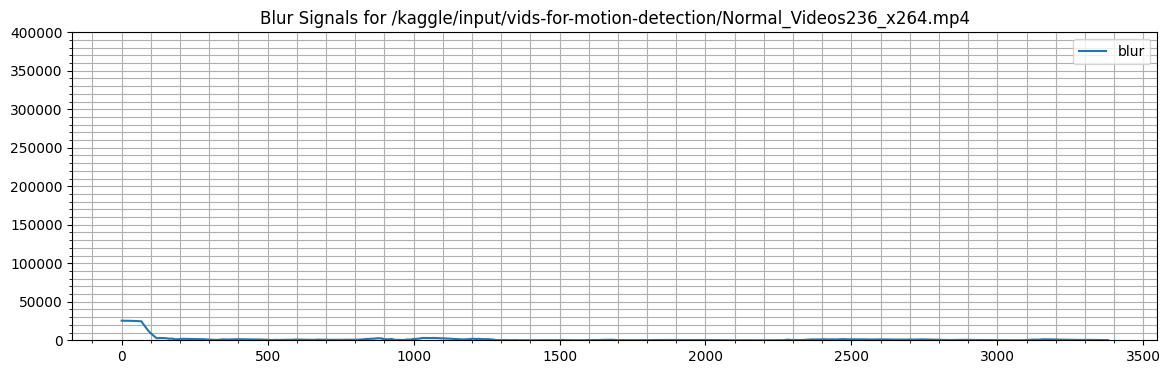

Processing video: /kaggle/input/vids-for-motion-detection/Normal_Videos243_x264.mp4
FPS: 30.0
Total frames: 1827


100%|██████████| 1827/1827.0 [00:04<00:00, 385.85it/s]


Raw SNR for /kaggle/input/vids-for-motion-detection/Normal_Videos243_x264.mp4: -2.71 dB


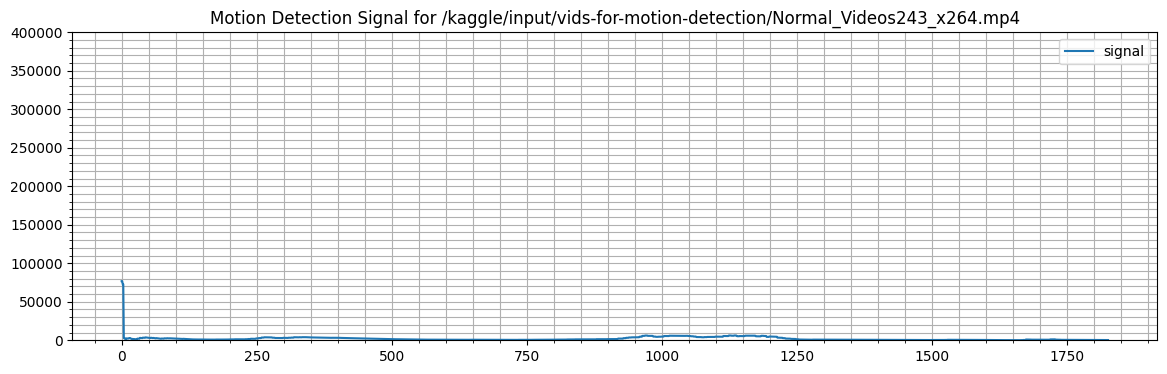

100%|██████████| 1827/1827.0 [00:05<00:00, 329.67it/s]


Blurred SNR for /kaggle/input/vids-for-motion-detection/Normal_Videos243_x264.mp4: -2.61 dB

SNR Comparison Table:
        Metric  Value (dB)
0      Raw SNR   -2.709449
1  Blurred SNR   -2.610067


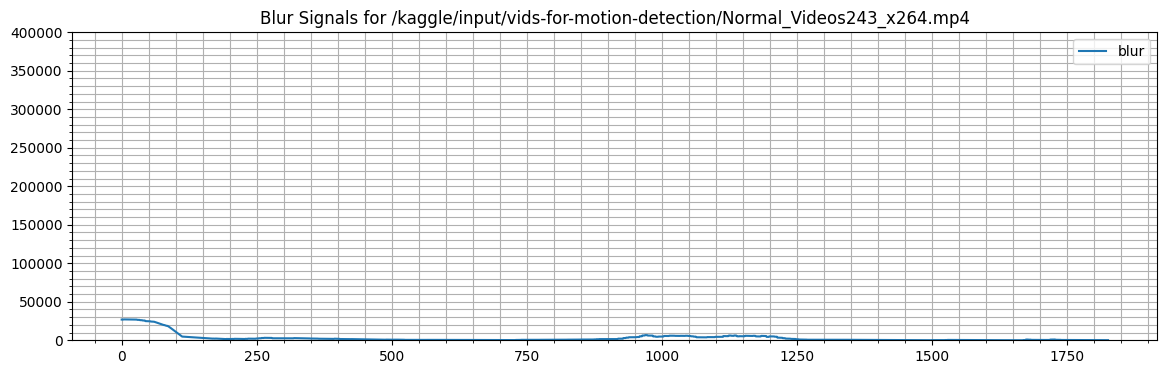

Processing video: /kaggle/input/vids-for-motion-detection/Normal_Videos244_x264.mp4
FPS: 30.0
Total frames: 2756


100%|██████████| 2756/2756.0 [00:06<00:00, 420.07it/s]


Raw SNR for /kaggle/input/vids-for-motion-detection/Normal_Videos244_x264.mp4: -2.43 dB


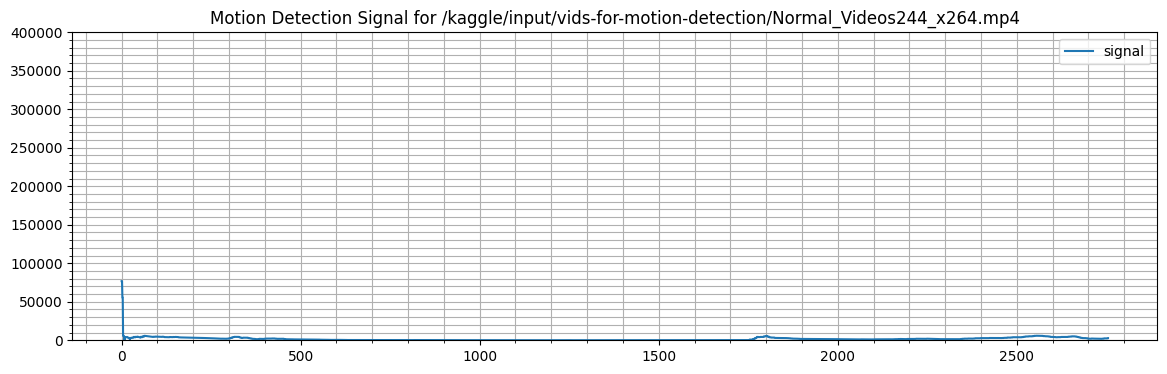

100%|██████████| 2756/2756.0 [00:07<00:00, 377.76it/s]


Blurred SNR for /kaggle/input/vids-for-motion-detection/Normal_Videos244_x264.mp4: -0.98 dB

SNR Comparison Table:
        Metric  Value (dB)
0      Raw SNR   -2.434312
1  Blurred SNR   -0.978681


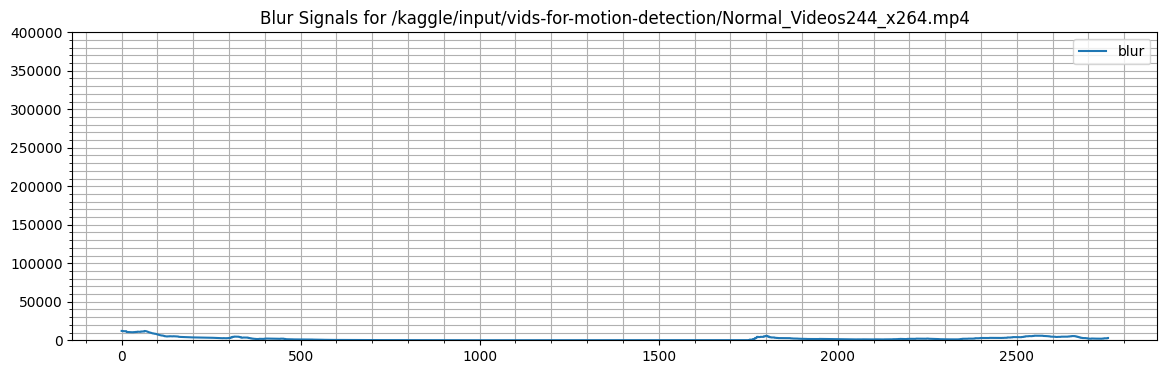

In [14]:
import cv2 as cv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

def calculate_snr(signal):
    """Calculate Signal-to-Noise Ratio (SNR)."""
    signal_mean = np.mean(signal)
    noise_std = np.std(signal)
    if noise_std == 0:  # Avoid division by zero
        return float('inf')  # High SNR if there's no noise
    return 10 * np.log10(signal_mean / noise_std)

def process_video(video_file):
    capture = cv.VideoCapture(video_file)
    print(f'Processing video: {video_file}')
    print(f'FPS: {capture.get(cv.CAP_PROP_FPS)}')
    print(f'Total frames: {int(capture.get(cv.CAP_PROP_FRAME_COUNT))}')
    
    backSub = cv.createBackgroundSubtractorKNN()
    
    masks = []
    
    # First pass: Get motion detection signals
    with tqdm(total=capture.get(cv.CAP_PROP_FRAME_COUNT)) as pbar:
        while True:
            ret, frame = capture.read()
            if not ret:  # Check if frame is valid
                break
            pbar.update(1)
            fgMask = backSub.apply(frame)
            masks.append(fgMask[fgMask > 0].shape[0])
    
    # Calculate SNR for the raw signal
    raw_snr = calculate_snr(masks)
    print(f'Raw SNR for {video_file}: {raw_snr:.2f} dB')
    
    df = pd.DataFrame({'signal': masks})
    ax = df.plot(figsize=(14, 4))
    ax.grid(axis='both', which='both')
    plt.minorticks_on()
    plt.ylim([0, 400000])
    plt.title(f'Motion Detection Signal for {video_file}')
    plt.show()

    # Filtering section
    filters = {
        'blur': {'filter': lambda x: cv.blur(x, (5, 5)), 'subtractor': backSub, 'signal': []},
    }

    # Reset the capture to start again
    capture.set(cv.CAP_PROP_POS_FRAMES, 0)

    # Second pass: Apply filters and get signals
    with tqdm(total=capture.get(cv.CAP_PROP_FRAME_COUNT)) as pbar:
        while True:
            ret, frame = capture.read()
            if not ret:  # Check if frame is valid
                break
            pbar.update(1)

            # Apply blur filter
            filtered_frame = filters['blur']['filter'](frame)
            mask = filters['blur']['subtractor'].apply(filtered_frame)
            filters['blur']['signal'].append(mask[mask > 0].shape[0])

    # Calculate SNR for the blurred signal
    blurred_signal = filters['blur']['signal']
    blurred_snr = calculate_snr(blurred_signal)
    print(f'Blurred SNR for {video_file}: {blurred_snr:.2f} dB')

    # Create a table to display SNR values
    snr_df = pd.DataFrame({
        'Metric': ['Raw SNR', 'Blurred SNR'],
        'Value (dB)': [raw_snr, blurred_snr]
    })
    
    print("\nSNR Comparison Table:")
    print(snr_df)

    # Plotting the blurred signal
    df = pd.DataFrame({
        'blur': filters['blur']['signal'],
    })

    ax = df.plot(figsize=(14, 4))
    ax.grid(axis='both', which='both')
    plt.minorticks_on()
    plt.ylim([0, 400000])
    plt.title(f'Blur Signals for {video_file}')
    plt.show()

# List of video files
video_files = [
    '/kaggle/input/vids-for-motion-detection/Normal_Videos020_x264.mp4',
    '/kaggle/input/vids-for-motion-detection/Normal_Videos071_x264.mp4',
    '/kaggle/input/vids-for-motion-detection/Normal_Videos093_x264.mp4',
    '/kaggle/input/vids-for-motion-detection/Normal_Videos099_x264.mp4',
    '/kaggle/input/vids-for-motion-detection/Normal_Videos114_x264.mp4',
    '/kaggle/input/vids-for-motion-detection/Normal_Videos149_x264.mp4',
    '/kaggle/input/vids-for-motion-detection/Normal_Videos162_x264.mp4',
    '/kaggle/input/vids-for-motion-detection/Normal_Videos178_x264.mp4',
    '/kaggle/input/vids-for-motion-detection/Normal_Videos209_x264.mp4',
    '/kaggle/input/vids-for-motion-detection/Normal_Videos222_x264.mp4',
    '/kaggle/input/vids-for-motion-detection/Normal_Videos236_x264.mp4',
    '/kaggle/input/vids-for-motion-detection/Normal_Videos243_x264.mp4',
    '/kaggle/input/vids-for-motion-detection/Normal_Videos244_x264.mp4',    
]

# Loop through all video files
for video_file in video_files:
    process_video(video_file)


Processing video: /kaggle/input/vids-for-motion-detection/Normal_Videos020_x264.mp4
FPS: 30.0
Total frames: 485


100%|██████████| 485/485.0 [00:02<00:00, 202.52it/s]


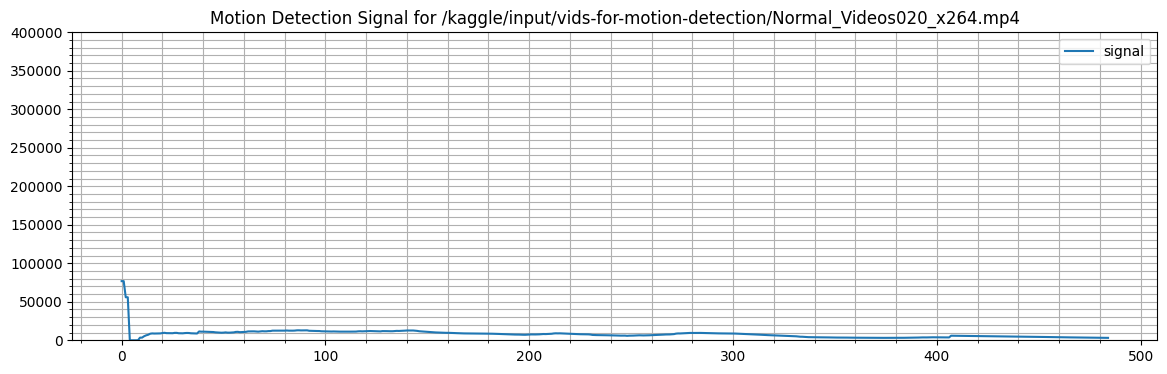

100%|██████████| 485/485.0 [00:02<00:00, 172.26it/s]


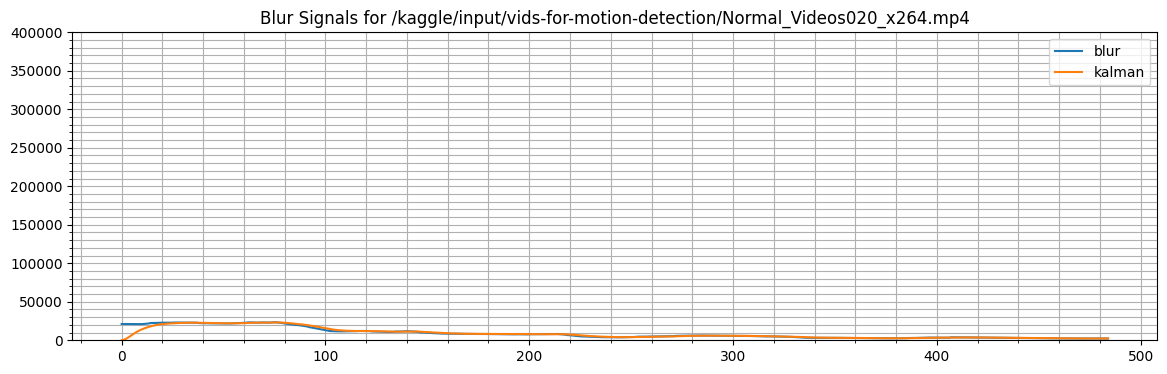

Processing video: /kaggle/input/vids-for-motion-detection/Normal_Videos071_x264.mp4
FPS: 30.0
Total frames: 871


100%|██████████| 871/871.0 [00:03<00:00, 260.31it/s]


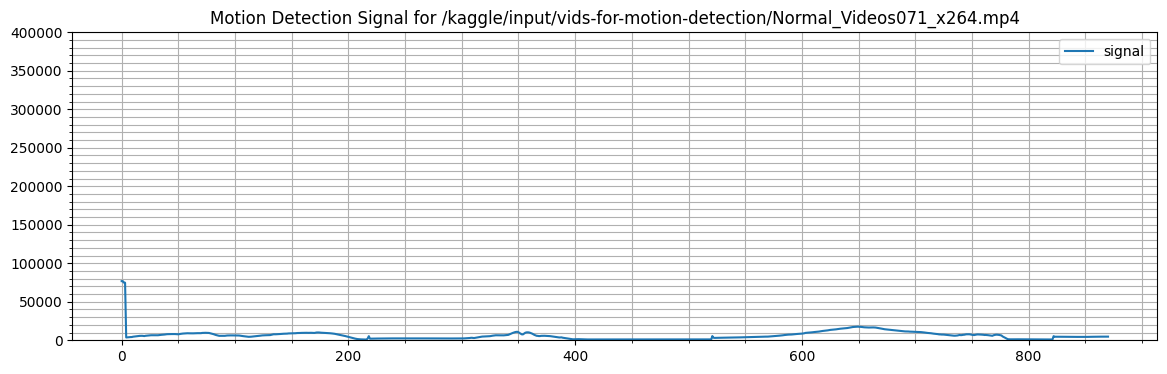

100%|██████████| 871/871.0 [00:04<00:00, 203.91it/s]


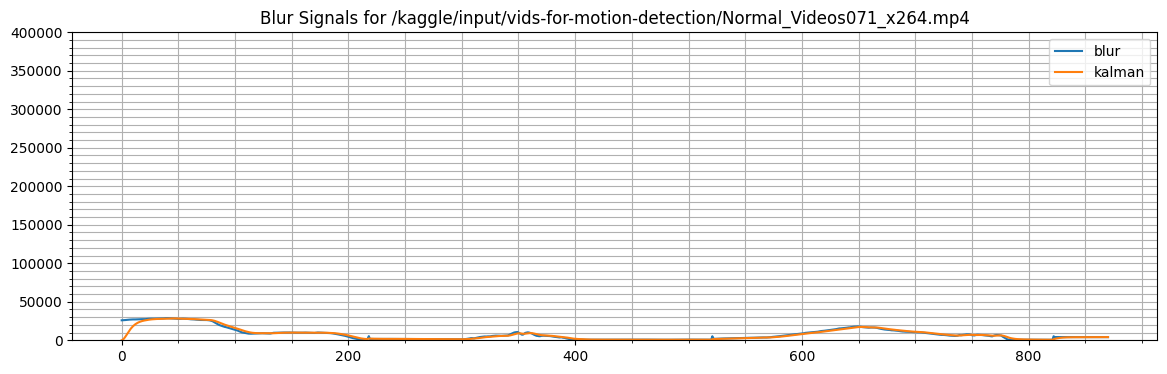

Processing video: /kaggle/input/vids-for-motion-detection/Normal_Videos093_x264.mp4
FPS: 30.0
Total frames: 1740


100%|██████████| 1740/1740.0 [00:03<00:00, 447.22it/s]


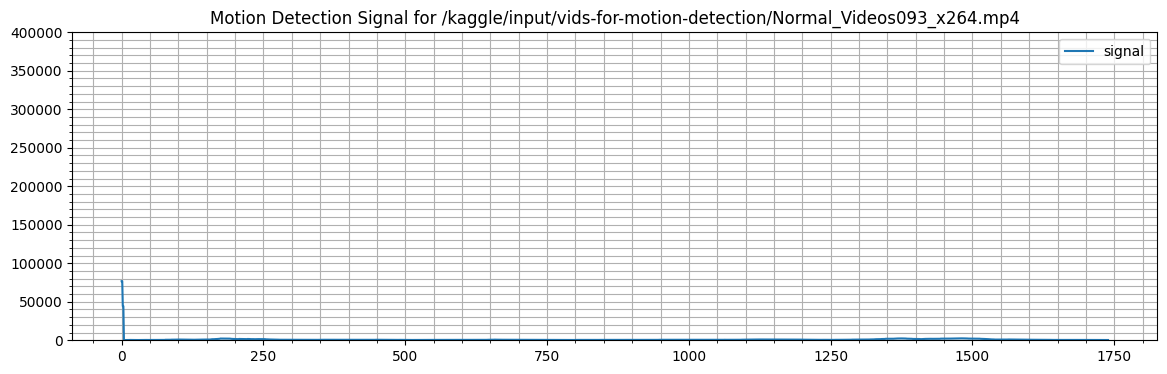

100%|██████████| 1740/1740.0 [00:04<00:00, 370.87it/s]


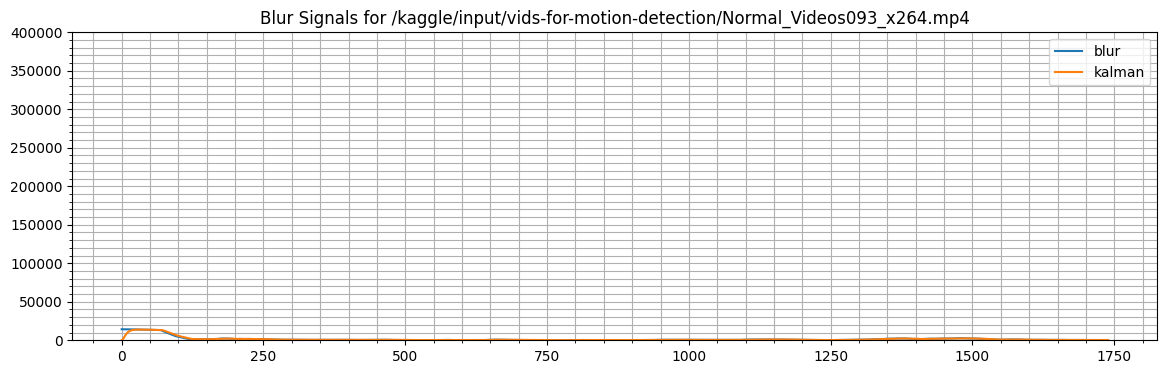

Processing video: /kaggle/input/vids-for-motion-detection/Normal_Videos099_x264.mp4
FPS: 30.0
Total frames: 2075


100%|██████████| 2075/2075.0 [00:04<00:00, 460.55it/s]


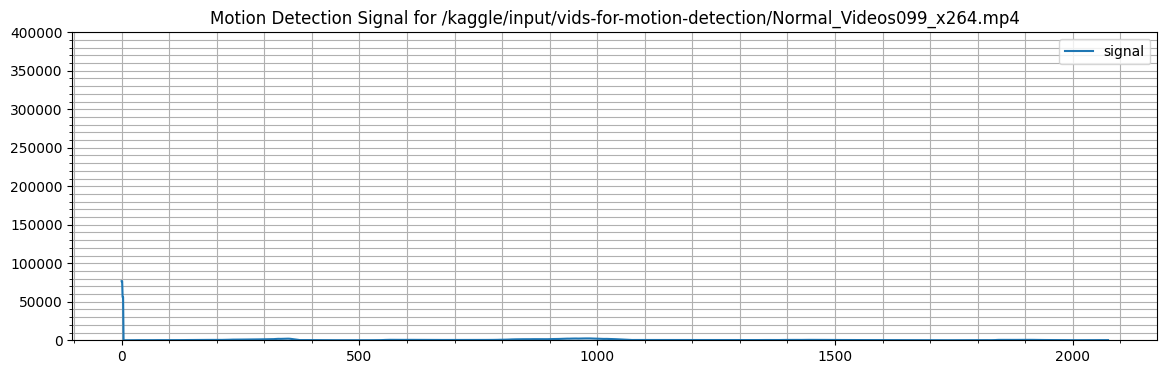

100%|██████████| 2075/2075.0 [00:05<00:00, 380.98it/s]


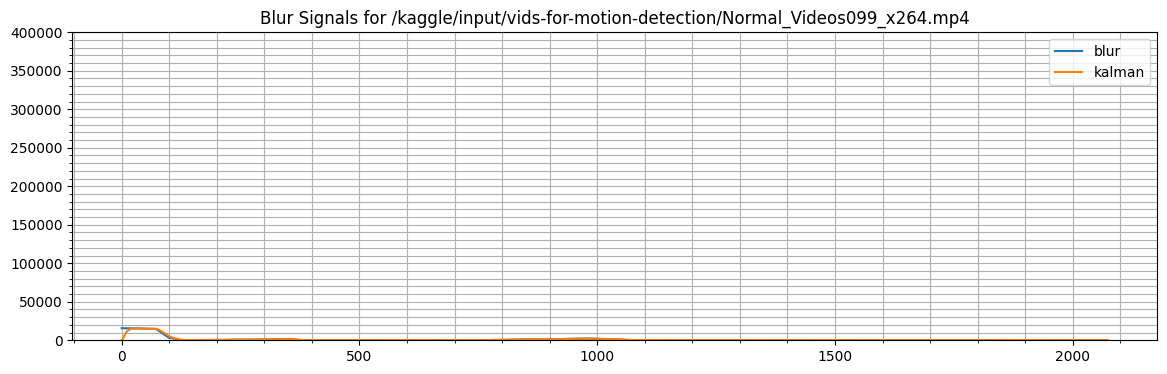

Processing video: /kaggle/input/vids-for-motion-detection/Normal_Videos114_x264.mp4
FPS: 30.0
Total frames: 1787


100%|██████████| 1787/1787.0 [00:04<00:00, 400.99it/s]


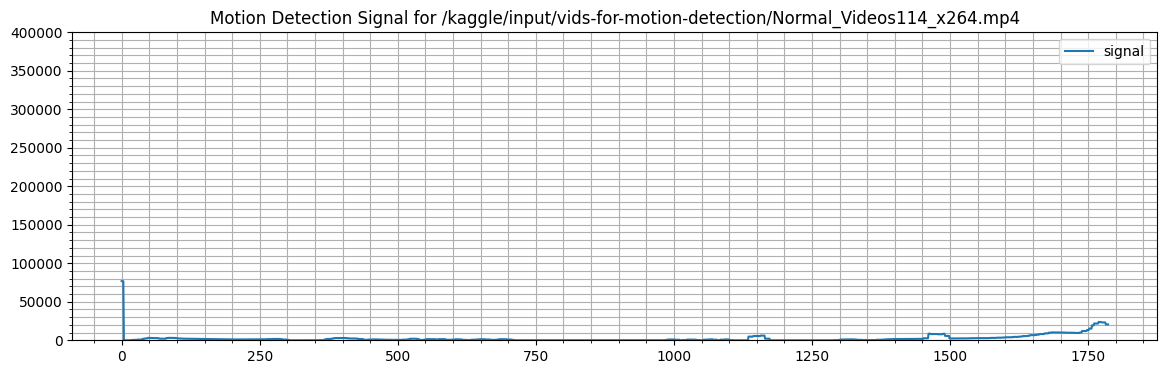

100%|██████████| 1787/1787.0 [00:05<00:00, 330.85it/s]


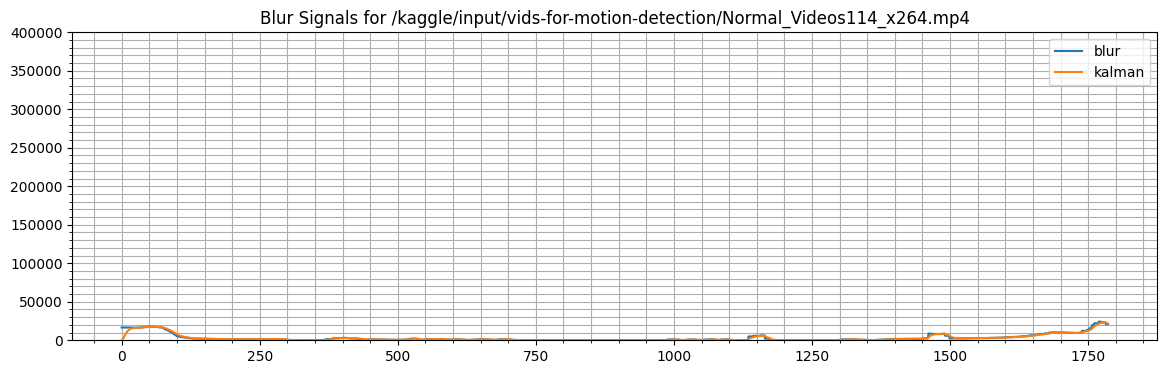

Processing video: /kaggle/input/vids-for-motion-detection/Normal_Videos149_x264.mp4
FPS: 30.0
Total frames: 1021


100%|██████████| 1021/1021.0 [00:04<00:00, 222.14it/s]


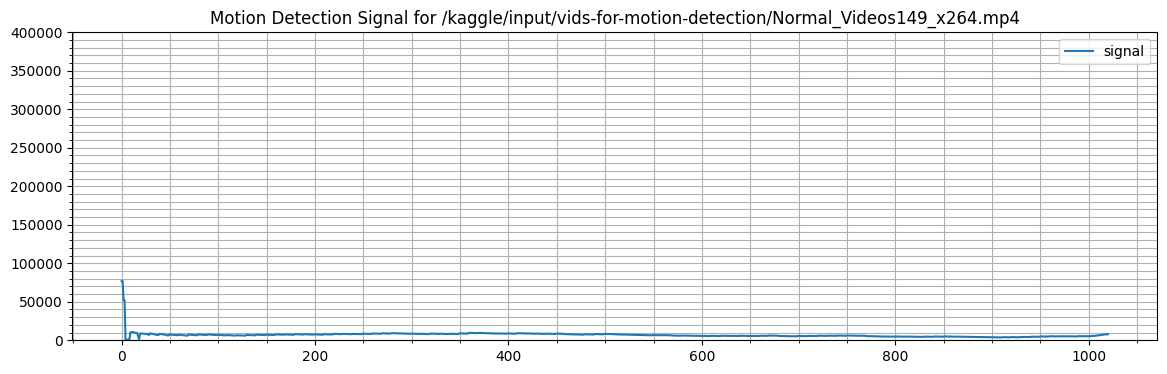

100%|██████████| 1021/1021.0 [00:05<00:00, 178.44it/s]


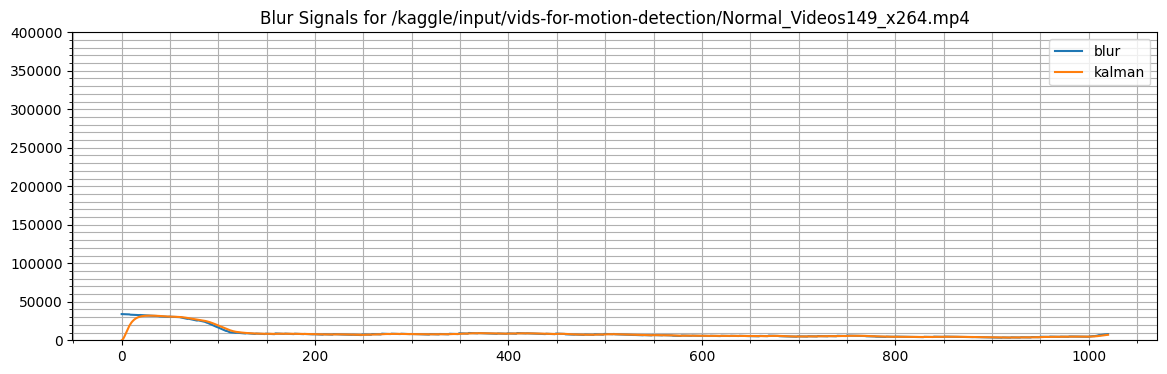

Processing video: /kaggle/input/vids-for-motion-detection/Normal_Videos162_x264.mp4
FPS: 30.0
Total frames: 1169


100%|██████████| 1169/1169.0 [00:03<00:00, 336.84it/s]


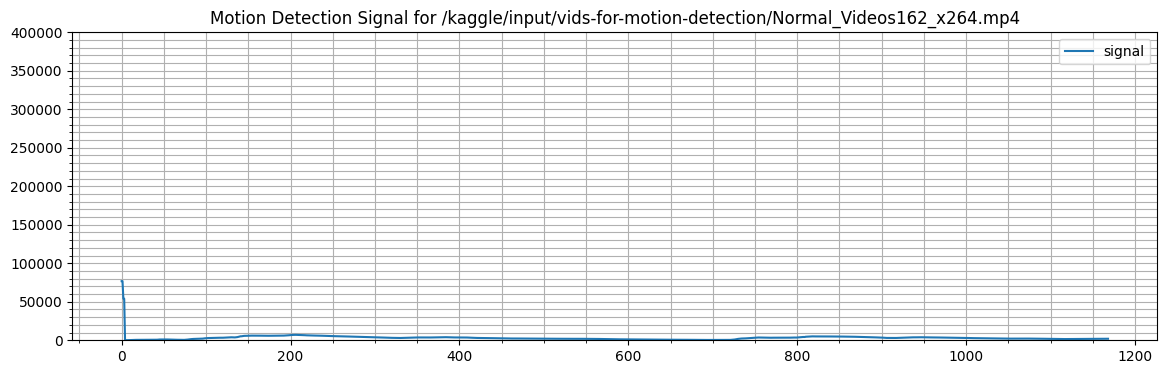

100%|██████████| 1169/1169.0 [00:04<00:00, 270.16it/s]


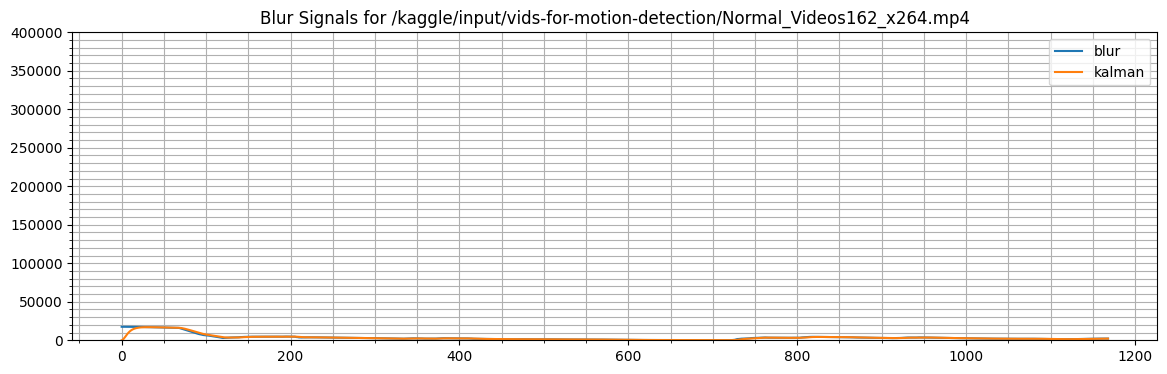

Processing video: /kaggle/input/vids-for-motion-detection/Normal_Videos178_x264.mp4
FPS: 30.0
Total frames: 1028


100%|██████████| 1028/1028.0 [00:03<00:00, 318.45it/s]


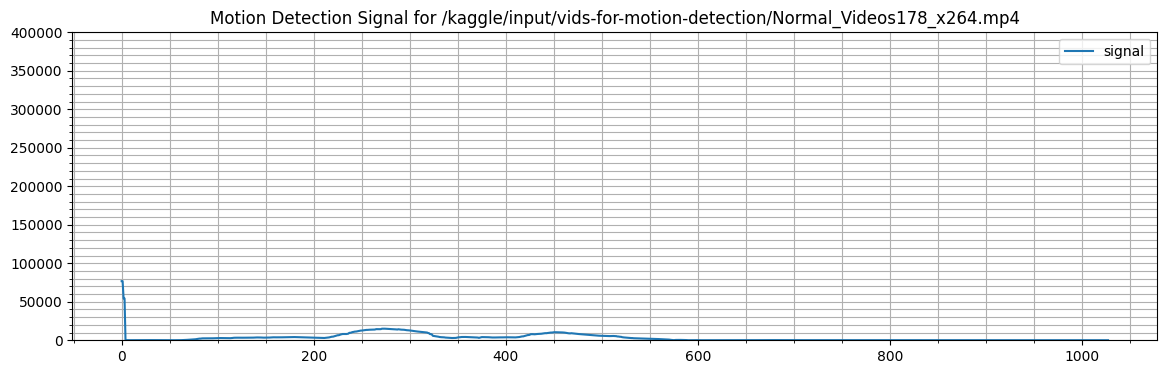

100%|██████████| 1028/1028.0 [00:03<00:00, 277.63it/s]


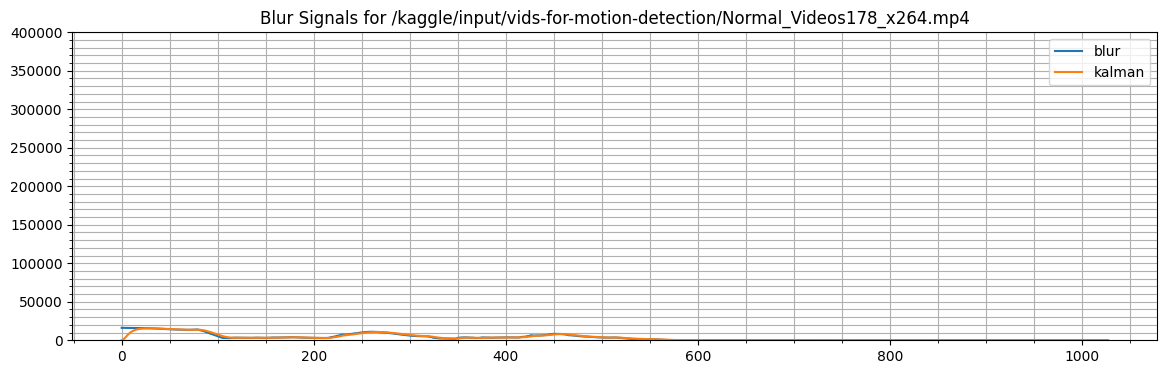

Processing video: /kaggle/input/vids-for-motion-detection/Normal_Videos209_x264.mp4
FPS: 30.0
Total frames: 633


100%|██████████| 633/633.0 [00:02<00:00, 284.38it/s]


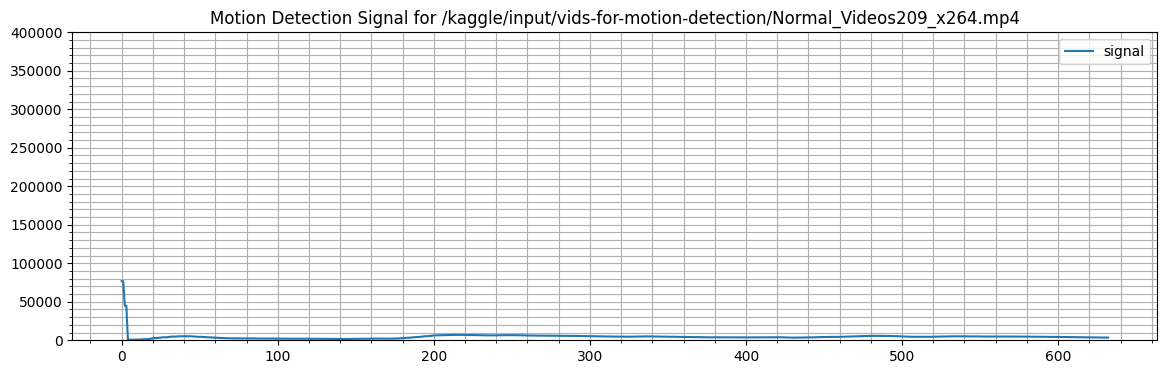

100%|██████████| 633/633.0 [00:02<00:00, 229.25it/s]


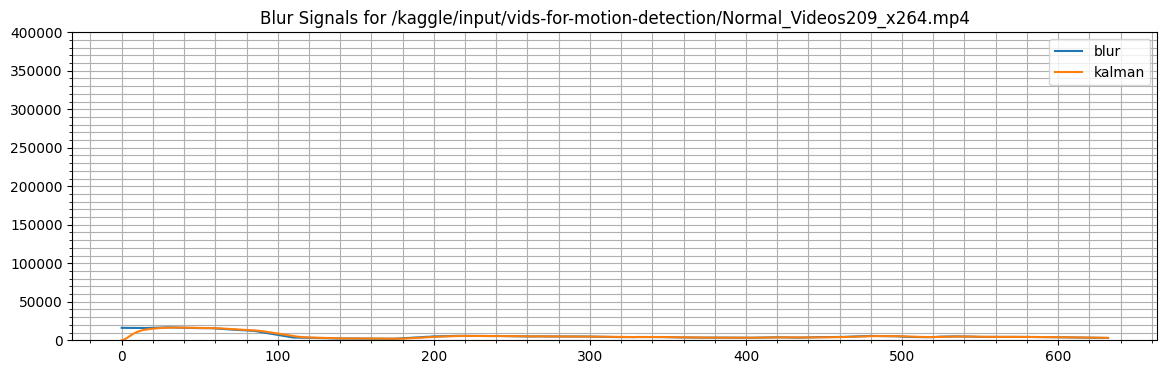

Processing video: /kaggle/input/vids-for-motion-detection/Normal_Videos222_x264.mp4
FPS: 30.0
Total frames: 949


100%|██████████| 949/949.0 [00:04<00:00, 221.53it/s]


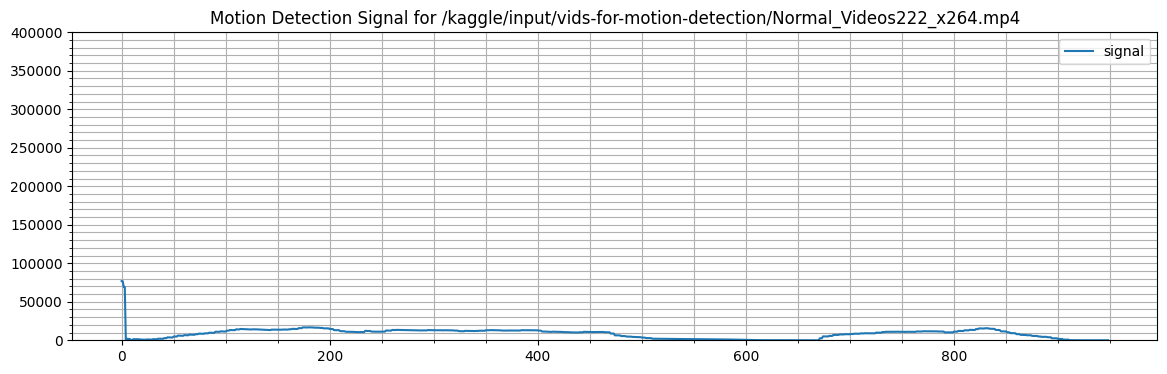

100%|██████████| 949/949.0 [00:04<00:00, 198.10it/s]


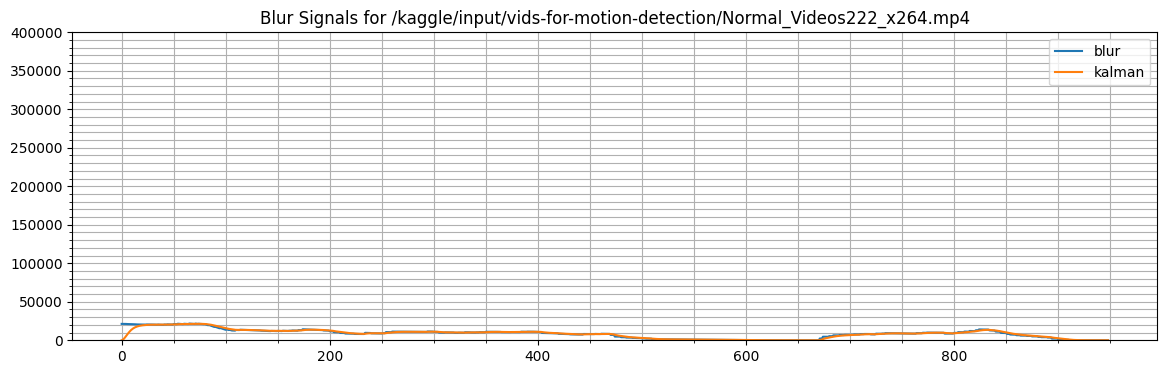

Processing video: /kaggle/input/vids-for-motion-detection/Normal_Videos236_x264.mp4
FPS: 30.0
Total frames: 3380


100%|██████████| 3380/3380.0 [00:07<00:00, 440.37it/s]


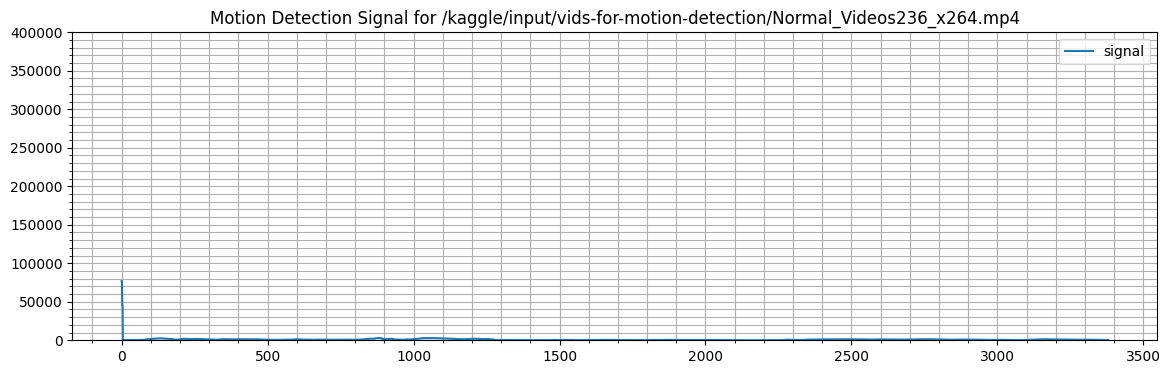

100%|██████████| 3380/3380.0 [00:08<00:00, 376.19it/s]


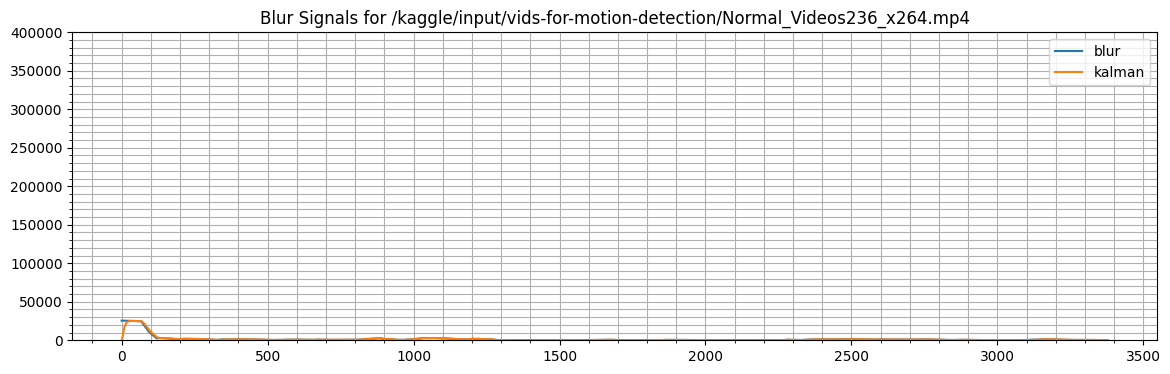

Processing video: /kaggle/input/vids-for-motion-detection/Normal_Videos243_x264.mp4
FPS: 30.0
Total frames: 1827


100%|██████████| 1827/1827.0 [00:04<00:00, 385.73it/s]


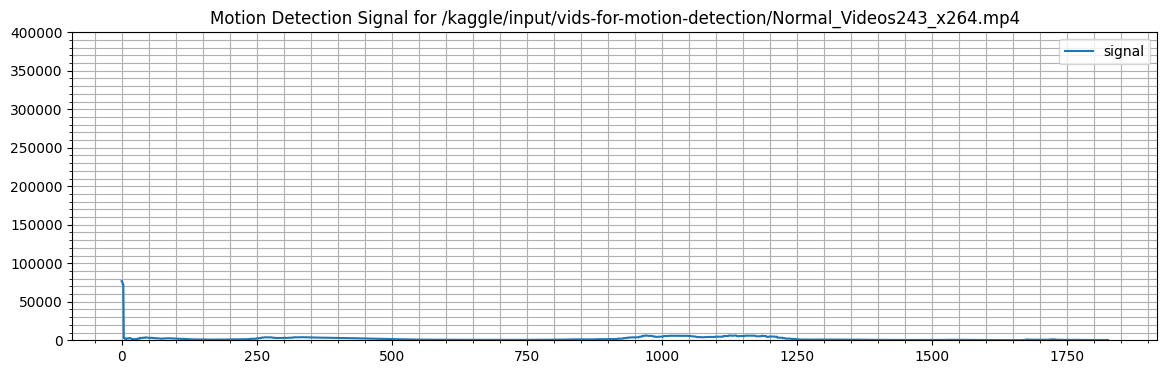

100%|██████████| 1827/1827.0 [00:05<00:00, 320.68it/s]


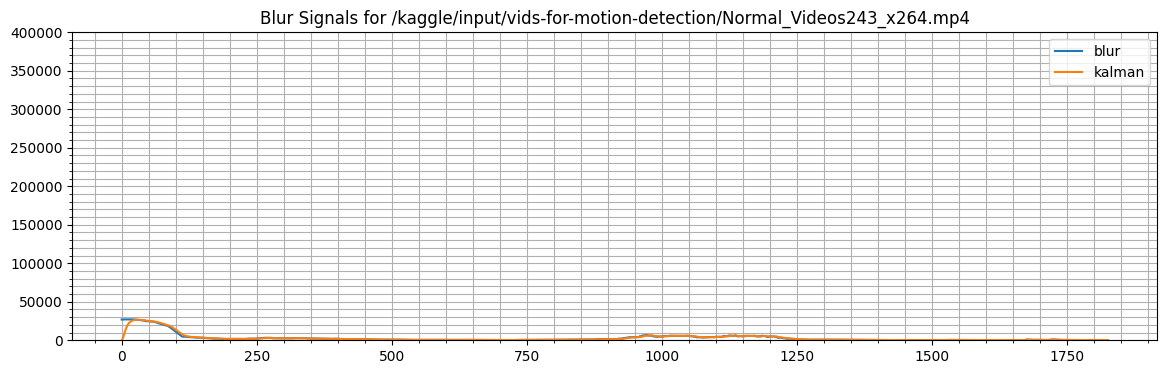

Processing video: /kaggle/input/vids-for-motion-detection/Normal_Videos244_x264.mp4
FPS: 30.0
Total frames: 2756


100%|██████████| 2756/2756.0 [00:06<00:00, 415.98it/s]


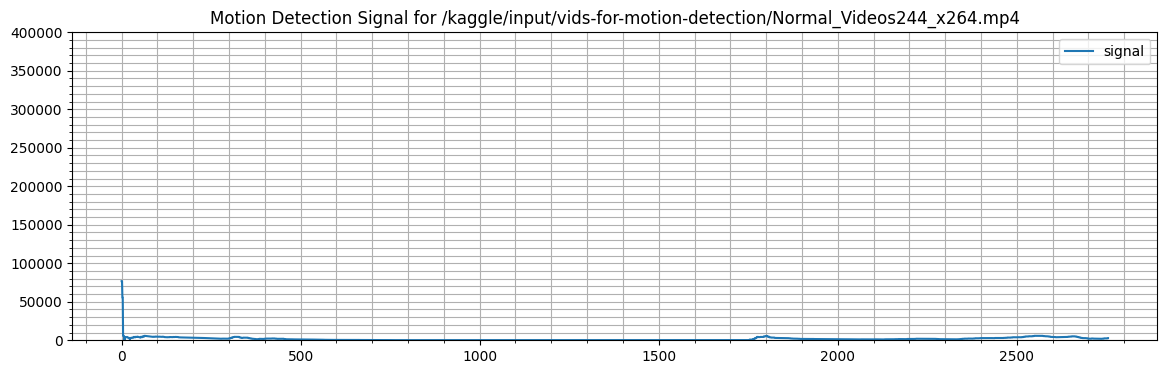

100%|██████████| 2756/2756.0 [00:07<00:00, 363.79it/s]


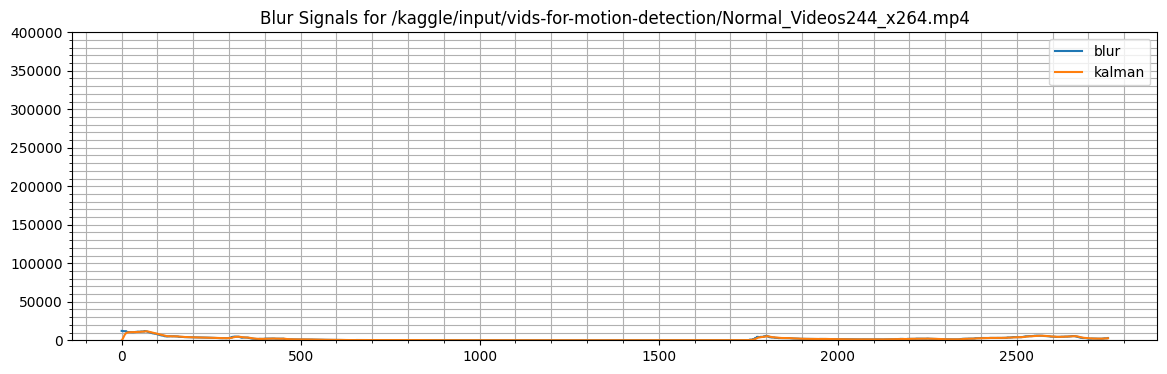

In [15]:
import cv2 as cv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

def process_video(video_file):
    capture = cv.VideoCapture(video_file)
    print(f'Processing video: {video_file}')
    print(f'FPS: {capture.get(cv.CAP_PROP_FPS)}')
    print(f'Total frames: {int(capture.get(cv.CAP_PROP_FRAME_COUNT))}')
    
    backSub = cv.createBackgroundSubtractorKNN()
    
    masks = []
    
    # First pass: Get motion detection signals
    with tqdm(total=capture.get(cv.CAP_PROP_FRAME_COUNT)) as pbar:
        while True:
            ret, frame = capture.read()
            if not ret:  # Check if frame is valid
                break
            pbar.update(1)
            fgMask = backSub.apply(frame)
            masks.append(fgMask[fgMask > 0].shape[0])
    
    df = pd.DataFrame({'signal': masks})
    ax = df.plot(figsize=(14, 4))
    ax.grid(axis='both', which='both')
    plt.minorticks_on()
    plt.ylim([0, 400000])
    plt.title(f'Motion Detection Signal for {video_file}')
    plt.show()

    # Kalman Filter setup
    kalman_arr = []
    kalman = cv.KalmanFilter(2, 1)
    kalman.measurementMatrix = np.array([[1, 0]], np.float32)
    kalman.transitionMatrix = np.array([[1, 0], [0, 1]], np.float32)
    kalman.processNoiseCov = np.array([[1, 0], [0, 1]], np.float32) * 0.03

    # Filtering section with only blur and Kalman
    filters = {
        'blur': {'filter': lambda x: cv.blur(x, (5, 5)), 'subtractor': backSub, 'signal': []},
        'kalman': {'filter': None, 'subtractor': None, 'signal': []},
    }

    # Reset the capture to start again
    capture.set(cv.CAP_PROP_POS_FRAMES, 0)

    # Second pass: Apply filters and get signals
    with tqdm(total=capture.get(cv.CAP_PROP_FRAME_COUNT)) as pbar:
        while True:
            ret, frame = capture.read()
            if not ret:  # Check if frame is valid
                break
            pbar.update(1)

            # Apply blur filter
            filtered_frame = filters['blur']['filter'](frame)
            mask = filters['blur']['subtractor'].apply(filtered_frame)
            filters['blur']['signal'].append(mask[mask > 0].shape[0])

            # Kalman filter prediction
            measurement = np.array([np.float32(mask[mask > 0].shape[0])])
            kalman.correct(measurement)
            prediction = kalman.predict()
            filters['kalman']['signal'].append(prediction[0][0])

    df = pd.DataFrame({
        'blur': filters['blur']['signal'],
        'kalman': filters['kalman']['signal'],
    })

    ax = df.plot(figsize=(14, 4))
    ax.grid(axis='both', which='both')
    plt.minorticks_on()
    plt.ylim([0, 400000])
    plt.title(f'Blur Signals for {video_file}')
    plt.show()

# List of video files
video_files = [
    '/kaggle/input/vids-for-motion-detection/Normal_Videos020_x264.mp4',
    '/kaggle/input/vids-for-motion-detection/Normal_Videos071_x264.mp4',
    '/kaggle/input/vids-for-motion-detection/Normal_Videos093_x264.mp4',
    '/kaggle/input/vids-for-motion-detection/Normal_Videos099_x264.mp4',
    '/kaggle/input/vids-for-motion-detection/Normal_Videos114_x264.mp4',
    '/kaggle/input/vids-for-motion-detection/Normal_Videos149_x264.mp4',
    '/kaggle/input/vids-for-motion-detection/Normal_Videos162_x264.mp4',
    '/kaggle/input/vids-for-motion-detection/Normal_Videos178_x264.mp4',
    '/kaggle/input/vids-for-motion-detection/Normal_Videos209_x264.mp4',
    '/kaggle/input/vids-for-motion-detection/Normal_Videos222_x264.mp4',
    '/kaggle/input/vids-for-motion-detection/Normal_Videos236_x264.mp4',
    '/kaggle/input/vids-for-motion-detection/Normal_Videos243_x264.mp4',
    '/kaggle/input/vids-for-motion-detection/Normal_Videos244_x264.mp4',
]

# Loop through all video files
for video_file in video_files:
    process_video(video_file)

Processing video: /kaggle/input/vids-for-motion-detection/Normal_Videos020_x264.mp4
FPS: 30.0
Total frames: 485


100%|██████████| 485/485.0 [00:02<00:00, 207.66it/s]
100%|██████████| 485/485.0 [00:02<00:00, 170.34it/s]


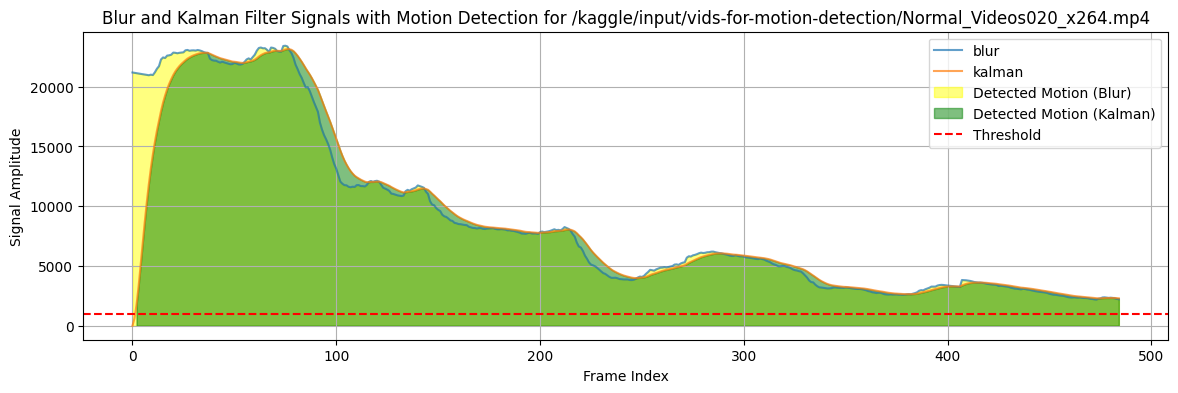

Processing video: /kaggle/input/vids-for-motion-detection/Normal_Videos071_x264.mp4
FPS: 30.0
Total frames: 871


100%|██████████| 871/871.0 [00:03<00:00, 265.66it/s]
100%|██████████| 871/871.0 [00:04<00:00, 207.20it/s]


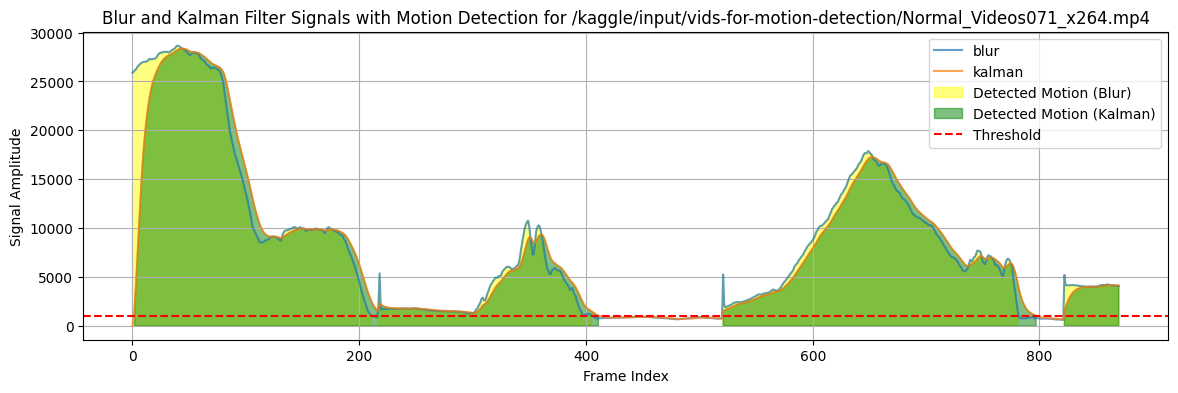

Processing video: /kaggle/input/vids-for-motion-detection/Normal_Videos093_x264.mp4
FPS: 30.0
Total frames: 1740


100%|██████████| 1740/1740.0 [00:03<00:00, 446.89it/s]
100%|██████████| 1740/1740.0 [00:04<00:00, 370.07it/s]


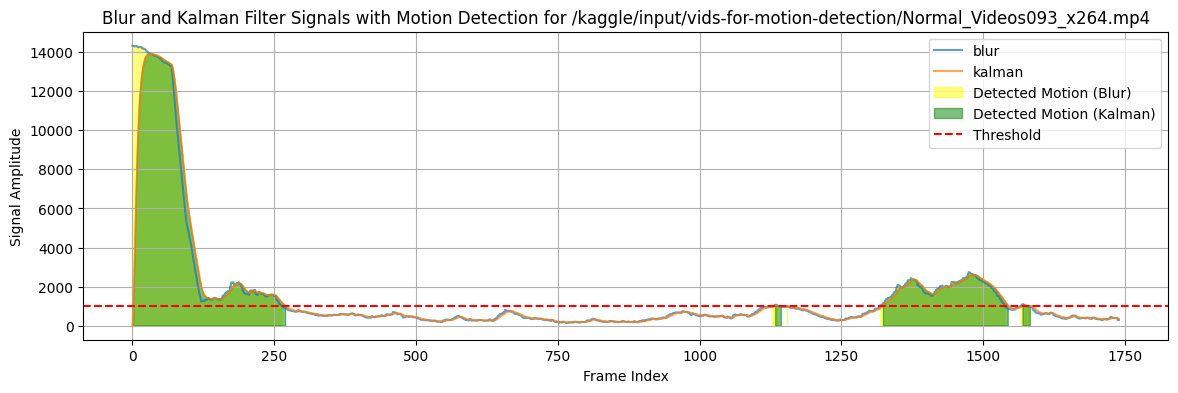

Processing video: /kaggle/input/vids-for-motion-detection/Normal_Videos099_x264.mp4
FPS: 30.0
Total frames: 2075


100%|██████████| 2075/2075.0 [00:04<00:00, 470.54it/s]
100%|██████████| 2075/2075.0 [00:05<00:00, 404.24it/s]


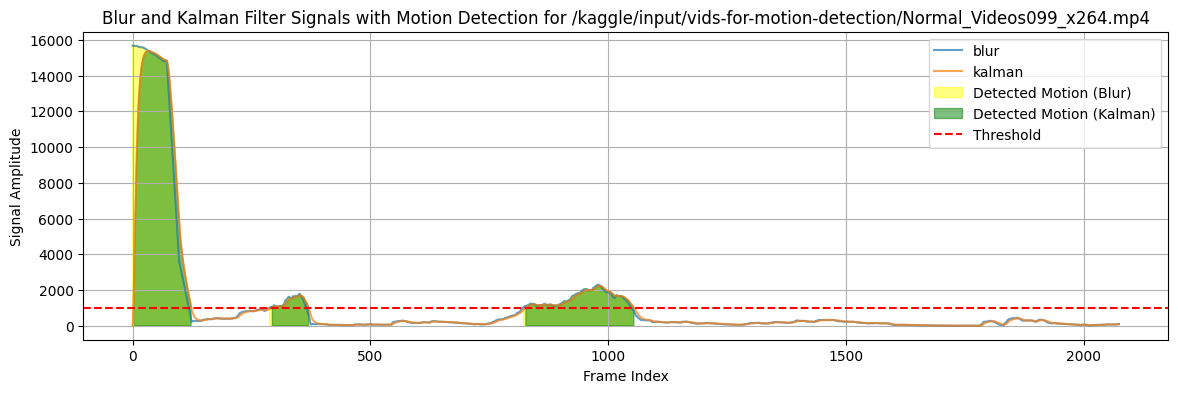

Processing video: /kaggle/input/vids-for-motion-detection/Normal_Videos114_x264.mp4
FPS: 30.0
Total frames: 1787


100%|██████████| 1787/1787.0 [00:04<00:00, 404.70it/s]
100%|██████████| 1787/1787.0 [00:05<00:00, 330.10it/s]


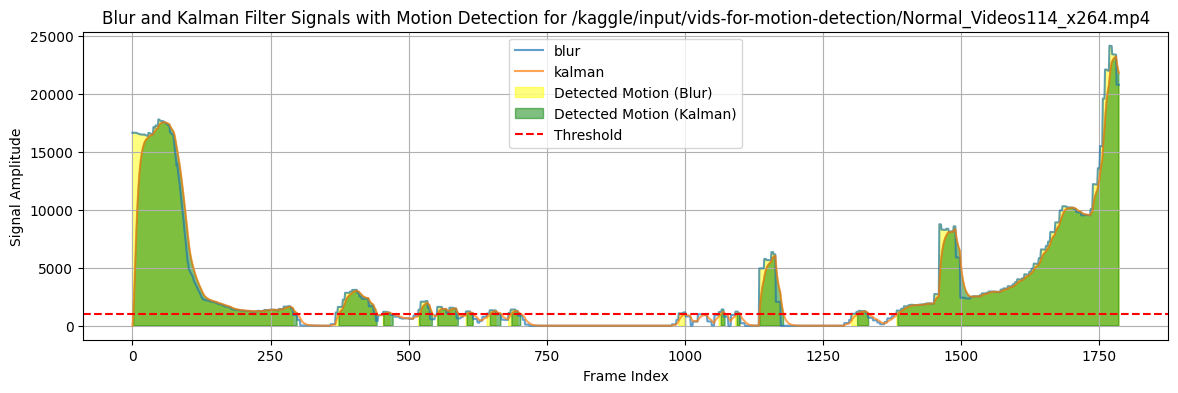

Processing video: /kaggle/input/vids-for-motion-detection/Normal_Videos149_x264.mp4
FPS: 30.0
Total frames: 1021


100%|██████████| 1021/1021.0 [00:04<00:00, 219.03it/s]
100%|██████████| 1021/1021.0 [00:05<00:00, 178.41it/s]


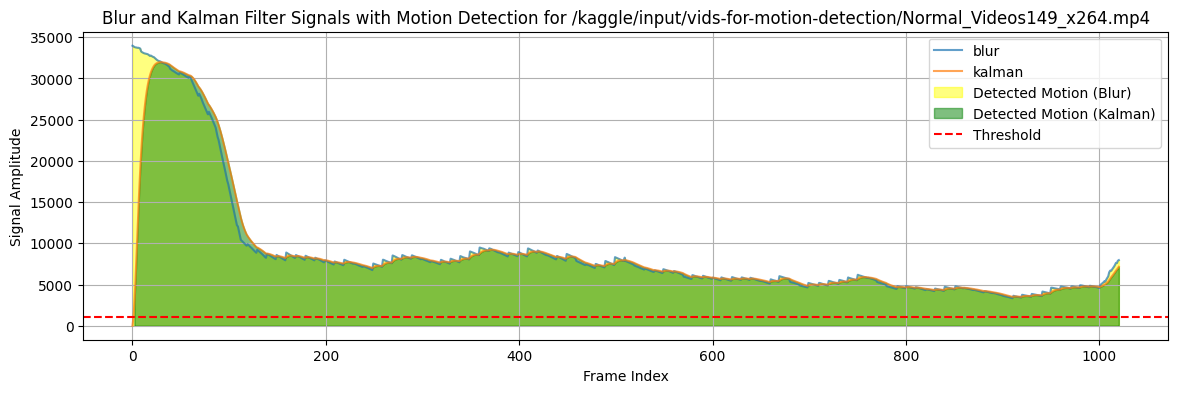

Processing video: /kaggle/input/vids-for-motion-detection/Normal_Videos162_x264.mp4
FPS: 30.0
Total frames: 1169


100%|██████████| 1169/1169.0 [00:03<00:00, 344.56it/s]
100%|██████████| 1169/1169.0 [00:04<00:00, 289.06it/s]


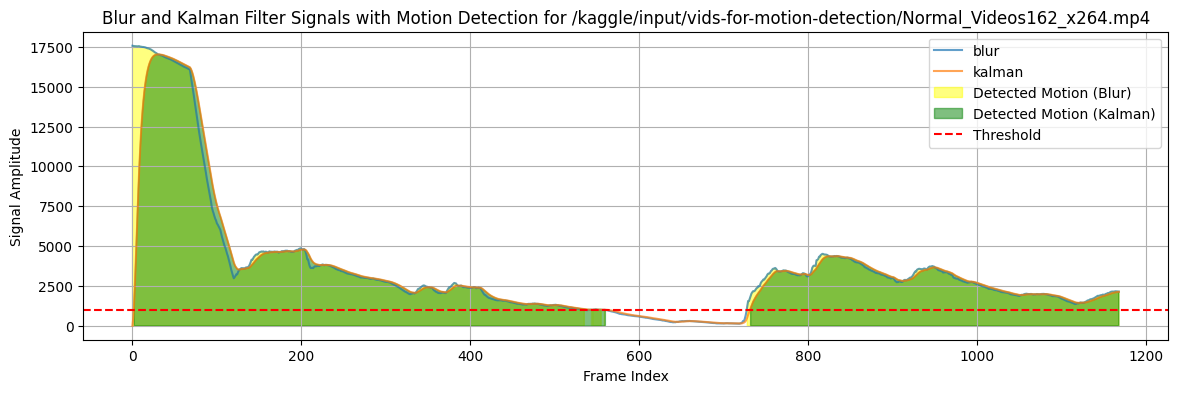

Processing video: /kaggle/input/vids-for-motion-detection/Normal_Videos178_x264.mp4
FPS: 30.0
Total frames: 1028


100%|██████████| 1028/1028.0 [00:03<00:00, 331.46it/s]
100%|██████████| 1028/1028.0 [00:03<00:00, 292.59it/s]


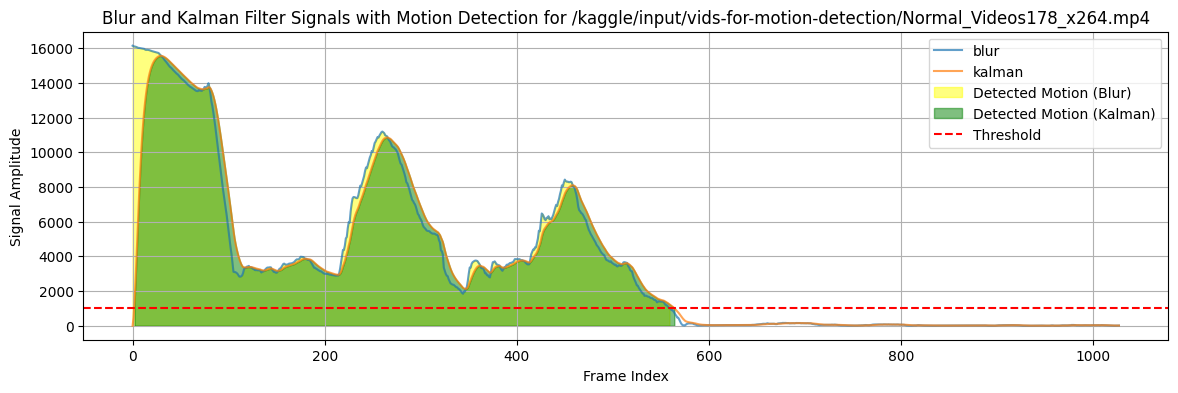

Processing video: /kaggle/input/vids-for-motion-detection/Normal_Videos209_x264.mp4
FPS: 30.0
Total frames: 633


100%|██████████| 633/633.0 [00:02<00:00, 291.35it/s]
100%|██████████| 633/633.0 [00:02<00:00, 230.09it/s]


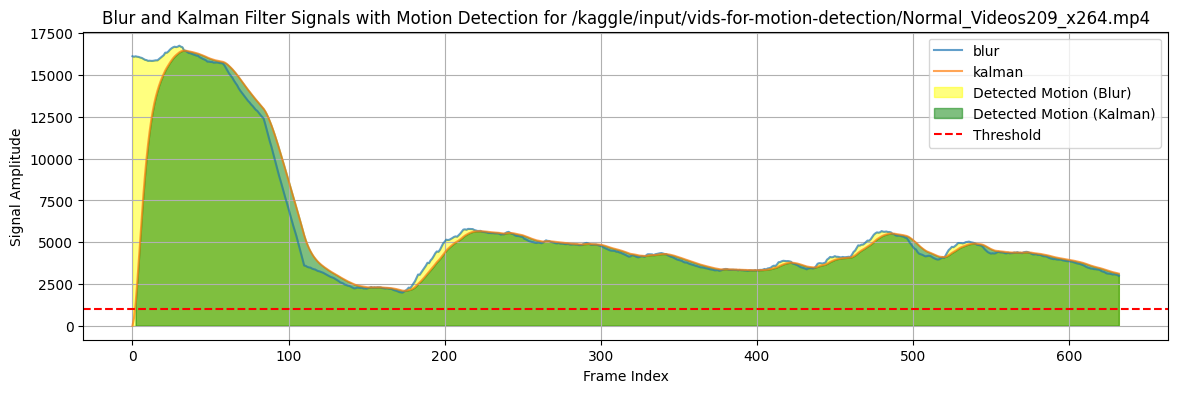

Processing video: /kaggle/input/vids-for-motion-detection/Normal_Videos222_x264.mp4
FPS: 30.0
Total frames: 949


100%|██████████| 949/949.0 [00:04<00:00, 227.88it/s]
100%|██████████| 949/949.0 [00:04<00:00, 197.01it/s]


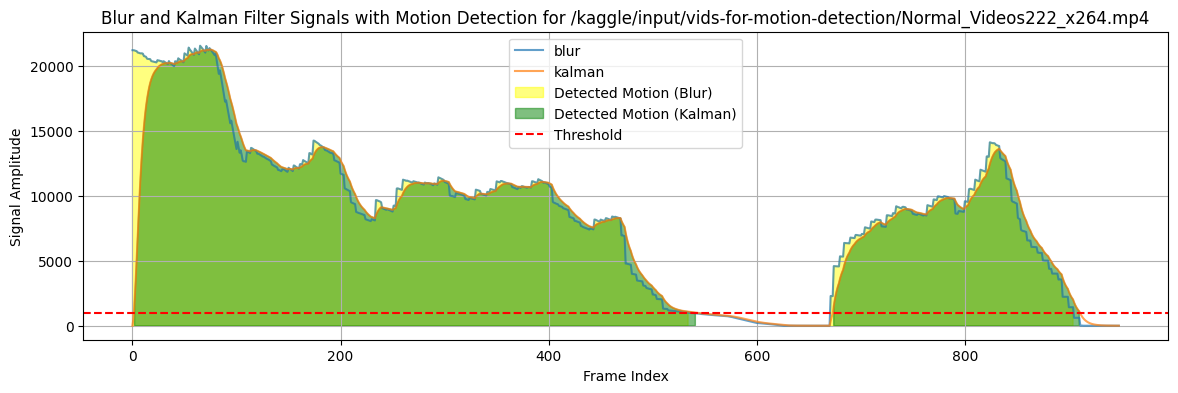

Processing video: /kaggle/input/vids-for-motion-detection/Normal_Videos236_x264.mp4
FPS: 30.0
Total frames: 3380


100%|██████████| 3380/3380.0 [00:07<00:00, 446.56it/s]
100%|██████████| 3380/3380.0 [00:08<00:00, 376.54it/s]


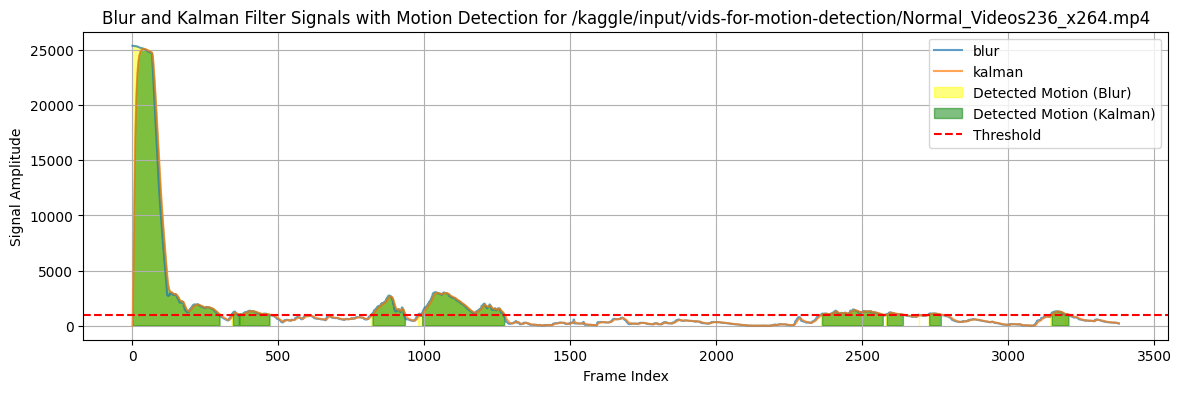

Processing video: /kaggle/input/vids-for-motion-detection/Normal_Videos243_x264.mp4
FPS: 30.0
Total frames: 1827


100%|██████████| 1827/1827.0 [00:04<00:00, 378.21it/s]
100%|██████████| 1827/1827.0 [00:05<00:00, 320.60it/s]


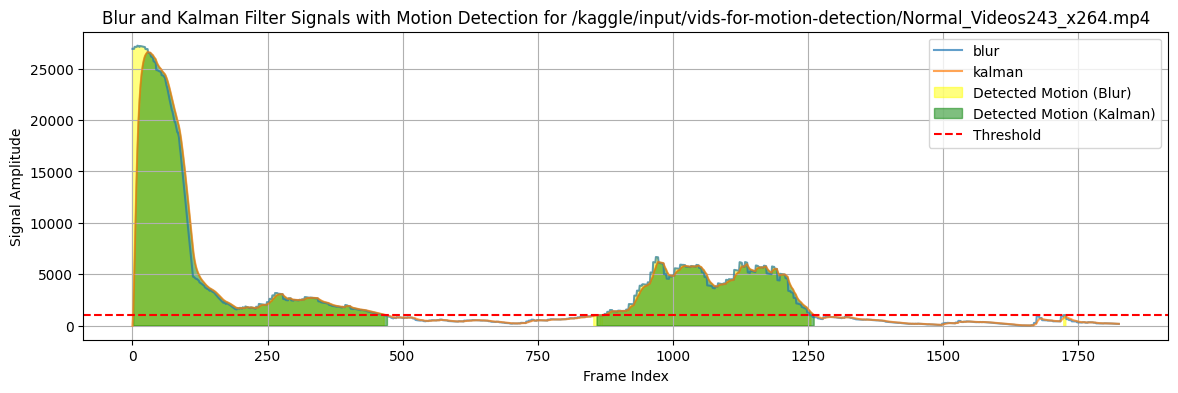

Processing video: /kaggle/input/vids-for-motion-detection/Normal_Videos244_x264.mp4
FPS: 30.0
Total frames: 2756


100%|██████████| 2756/2756.0 [00:06<00:00, 416.16it/s]
100%|██████████| 2756/2756.0 [00:07<00:00, 364.98it/s]


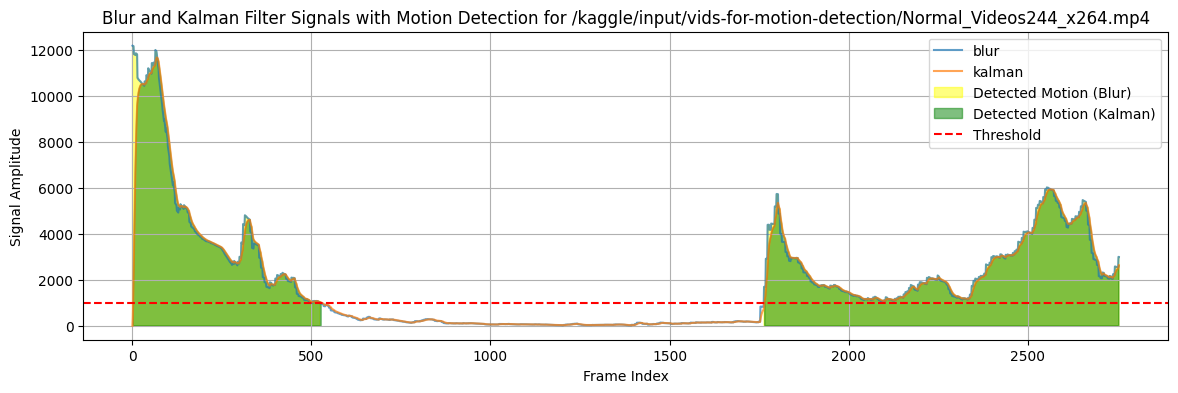

In [16]:
import cv2 as cv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

def process_video(video_file, threshold=1000):
    capture = cv.VideoCapture(video_file)
    print(f'Processing video: {video_file}')
    print(f'FPS: {capture.get(cv.CAP_PROP_FPS)}')
    print(f'Total frames: {int(capture.get(cv.CAP_PROP_FRAME_COUNT))}')
    
    backSub = cv.createBackgroundSubtractorKNN()
    
    masks = []
    
    # First pass: Get motion detection signals
    with tqdm(total=capture.get(cv.CAP_PROP_FRAME_COUNT)) as pbar:
        while True:
            ret, frame = capture.read()
            if not ret:  # Check if frame is valid
                break
            pbar.update(1)
            fgMask = backSub.apply(frame)
            masks.append(fgMask[fgMask > 0].shape[0])
    
    # Initialize Kalman Filter
    kalman = cv.KalmanFilter(2, 1)
    kalman.measurementMatrix = np.array([[1, 0]], np.float32)
    kalman.transitionMatrix = np.array([[1, 0], [0, 1]], np.float32)
    kalman.processNoiseCov = np.array([[1, 0], [0, 1]], np.float32) * 0.03

    # Filtering section with blur and Kalman
    filters = {
        'blur': {'filter': lambda x: cv.blur(x, (5, 5)), 'subtractor': backSub, 'signal': []},
        'kalman': {'signal': []},
    }

    # Reset the capture to start again
    capture.set(cv.CAP_PROP_POS_FRAMES, 0)

    # Second pass: Apply filters and get signals
    with tqdm(total=capture.get(cv.CAP_PROP_FRAME_COUNT)) as pbar:
        while True:
            ret, frame = capture.read()
            if not ret:  # Check if frame is valid
                break
            pbar.update(1)

            # Apply blur filter
            filtered_frame = filters['blur']['filter'](frame)
            mask = filters['blur']['subtractor'].apply(filtered_frame)
            filters['blur']['signal'].append(mask[mask > 0].shape[0])

            # Kalman filter prediction
            measurement = np.array([np.float32(mask[mask > 0].shape[0])])
            kalman.correct(measurement)
            prediction = kalman.predict()
            filters['kalman']['signal'].append(prediction[0][0])

    df = pd.DataFrame({
        'blur': filters['blur']['signal'],
        'kalman': filters['kalman']['signal'],
    })

    # Apply thresholding
    df['motion_detected_blur'] = df['blur'] > threshold
    df['motion_detected_kalman'] = df['kalman'] > threshold

    # Calculate True Positives, False Positives, False Negatives
    # For example, let's assume you have a true motion label array `true_labels`
    # true_labels = ... # This should be a boolean array indicating true motion (1) or not (0)
    # TP = np.sum(df['motion_detected_blur'] & true_labels)
    # FP = np.sum(df['motion_detected_blur'] & ~true_labels)
    # FN = np.sum(~df['motion_detected_blur'] & true_labels)

    # Plotting the signals
    ax = df[['blur', 'kalman']].plot(figsize=(14, 4), alpha=0.7)
    ax.fill_between(df.index, 0, df['blur'], where=df['motion_detected_blur'], color='yellow', alpha=0.5, label='Detected Motion (Blur)')
    ax.fill_between(df.index, 0, df['kalman'], where=df['motion_detected_kalman'], color='green', alpha=0.5, label='Detected Motion (Kalman)')
    ax.axhline(y=threshold, color='red', linestyle='--', label='Threshold')
    
    plt.title(f'Blur and Kalman Filter Signals with Motion Detection for {video_file}')
    plt.xlabel('Frame Index')
    plt.ylabel('Signal Amplitude')
    plt.legend()
    plt.grid()
    plt.show()

# List of video files
video_files = [
    '/kaggle/input/vids-for-motion-detection/Normal_Videos020_x264.mp4',
    '/kaggle/input/vids-for-motion-detection/Normal_Videos071_x264.mp4',
    '/kaggle/input/vids-for-motion-detection/Normal_Videos093_x264.mp4',
    '/kaggle/input/vids-for-motion-detection/Normal_Videos099_x264.mp4',
    '/kaggle/input/vids-for-motion-detection/Normal_Videos114_x264.mp4',
    '/kaggle/input/vids-for-motion-detection/Normal_Videos149_x264.mp4',
    '/kaggle/input/vids-for-motion-detection/Normal_Videos162_x264.mp4',
    '/kaggle/input/vids-for-motion-detection/Normal_Videos178_x264.mp4',
    '/kaggle/input/vids-for-motion-detection/Normal_Videos209_x264.mp4',
    '/kaggle/input/vids-for-motion-detection/Normal_Videos222_x264.mp4',
    '/kaggle/input/vids-for-motion-detection/Normal_Videos236_x264.mp4',
    '/kaggle/input/vids-for-motion-detection/Normal_Videos243_x264.mp4',
    '/kaggle/input/vids-for-motion-detection/Normal_Videos244_x264.mp4',    
]

# Loop through all video files
for video_file in video_files:
    process_video(video_file)


In [17]:
import cv2 as cv
import pandas as pd
import numpy as np

def label_video_frames(video_file, threshold=1000):
    capture = cv.VideoCapture(video_file)
    frame_labels = []

    # Background subtractor and Kalman filter initialization
    backSub = cv.createBackgroundSubtractorKNN()
    kalman = cv.KalmanFilter(2, 1)
    kalman.measurementMatrix = np.array([[1, 0]], np.float32)
    kalman.transitionMatrix = np.array([[1, 0], [0, 1]], np.float32)
    kalman.processNoiseCov = np.array([[1, 0], [0, 1]], np.float32) * 0.03

    while True:
        ret, frame = capture.read()
        if not ret:
            break

        # Apply blur filter
        blurred_frame = cv.blur(frame, (5, 5))
        
        # Apply background subtraction
        fgMask = backSub.apply(blurred_frame)
        motion_pixels = np.sum(fgMask > 0)

        # Kalman filter prediction and correction
        measurement = np.array([[np.float32(motion_pixels)]])
        kalman.correct(measurement)
        prediction = kalman.predict()

        # Label based on motion pixels after Kalman filtering
        label = 1 if prediction[0][0] > threshold else 0
        frame_labels.append((capture.get(cv.CAP_PROP_POS_FRAMES), label))

    capture.release()
    return frame_labels

# Example usage
video_files = [
    '/kaggle/input/vids-for-motion-detection/Normal_Videos020_x264.mp4',
    '/kaggle/input/vids-for-motion-detection/Normal_Videos071_x264.mp4',
    '/kaggle/input/vids-for-motion-detection/Normal_Videos093_x264.mp4',
    '/kaggle/input/vids-for-motion-detection/Normal_Videos099_x264.mp4',
    '/kaggle/input/vids-for-motion-detection/Normal_Videos114_x264.mp4',
    '/kaggle/input/vids-for-motion-detection/Normal_Videos149_x264.mp4',
    '/kaggle/input/vids-for-motion-detection/Normal_Videos162_x264.mp4',
    '/kaggle/input/vids-for-motion-detection/Normal_Videos178_x264.mp4',
    '/kaggle/input/vids-for-motion-detection/Normal_Videos209_x264.mp4',
    '/kaggle/input/vids-for-motion-detection/Normal_Videos222_x264.mp4',
    '/kaggle/input/vids-for-motion-detection/Normal_Videos236_x264.mp4',
    '/kaggle/input/vids-for-motion-detection/Normal_Videos243_x264.mp4',
    '/kaggle/input/vids-for-motion-detection/Normal_Videos244_x264.mp4',
]

all_labels = {}
for video_file in video_files:
    labels = label_video_frames(video_file)
    all_labels[video_file] = labels

# Convert to DataFrame for further use
label_df = pd.DataFrame([(vid, frame, label) for vid, frames in all_labels.items() for frame, label in frames], 
                        columns=['video_id', 'frame_index', 'label'])

# Save to CSV
label_df.to_csv('motion_detected_labels.csv', index=False)


Overall Performance Metrics:
Accuracy: 0.96
Precision: 0.97
Recall: 0.95
F1 Score: 0.96


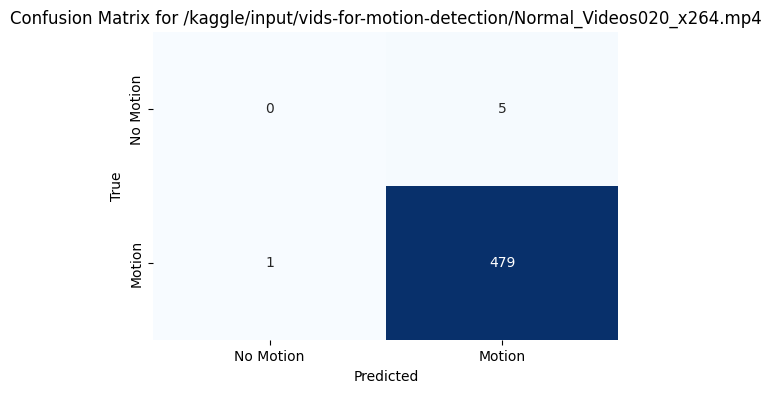

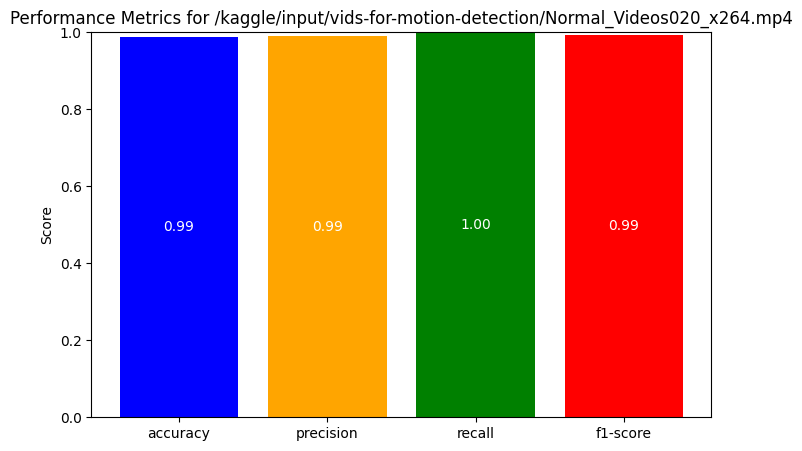

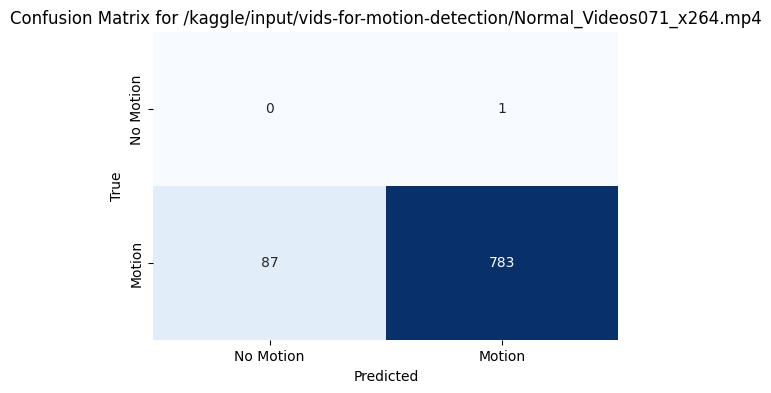

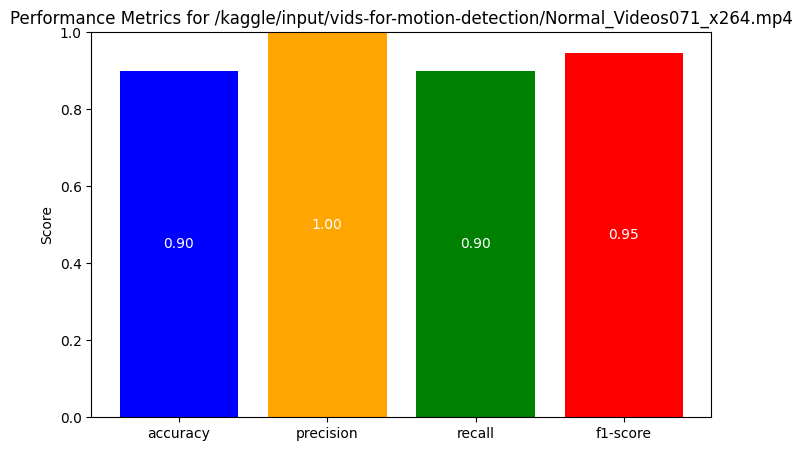

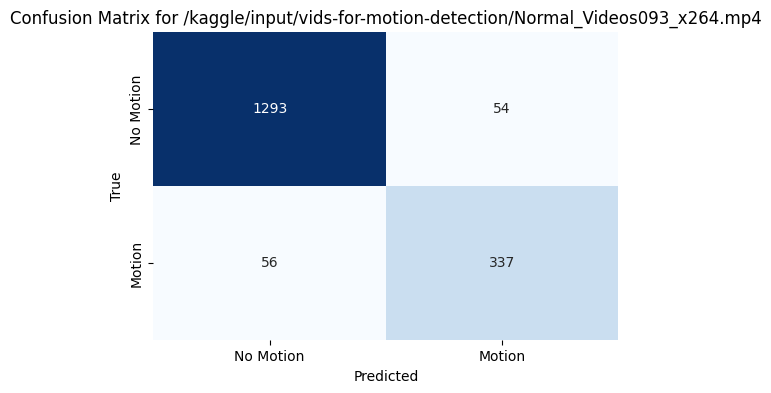

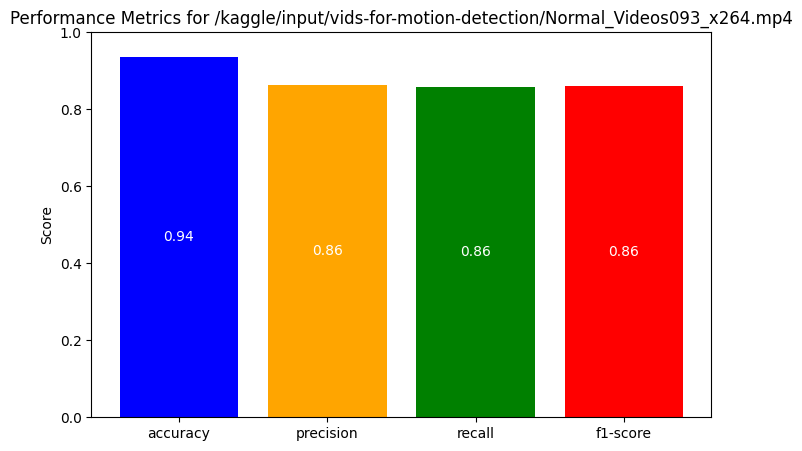

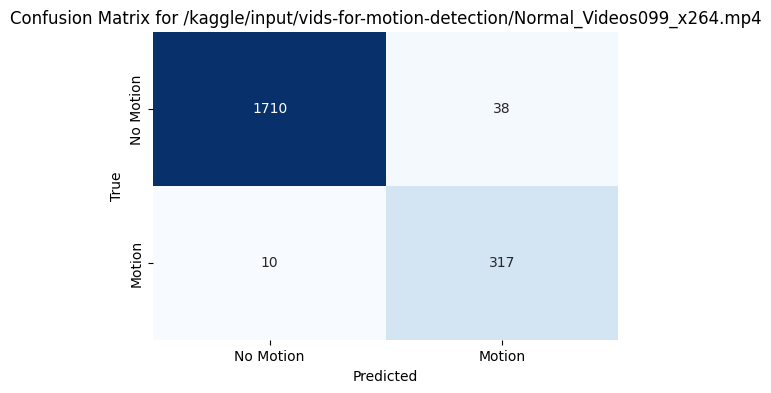

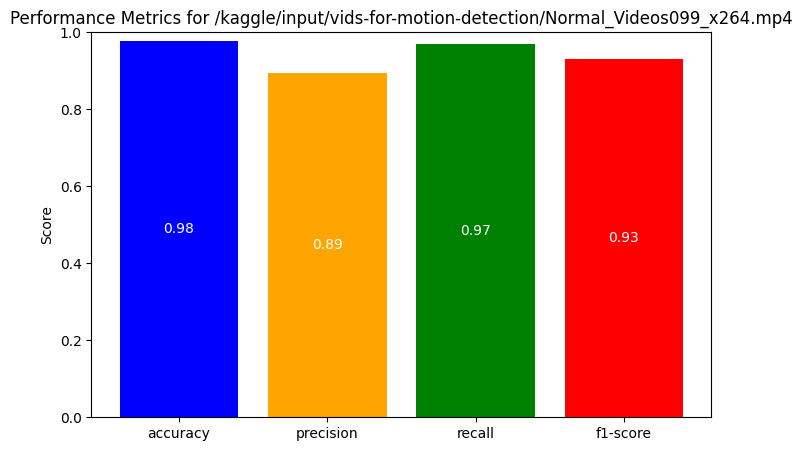

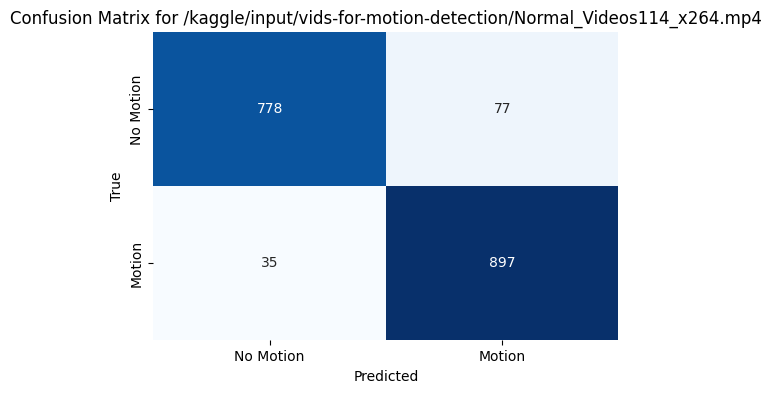

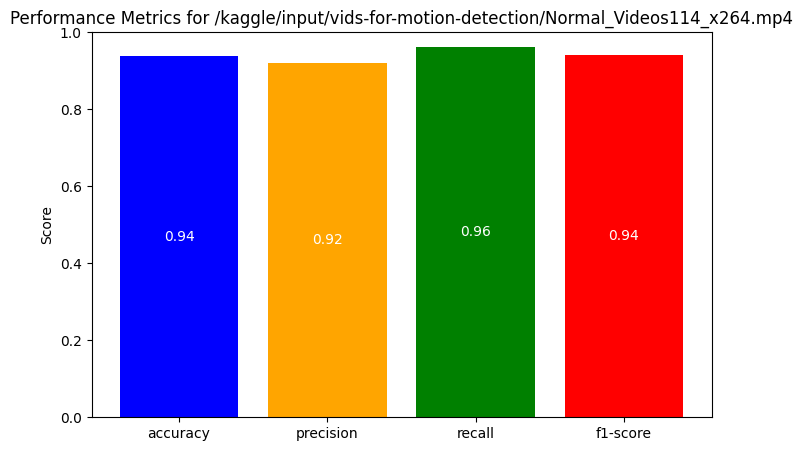

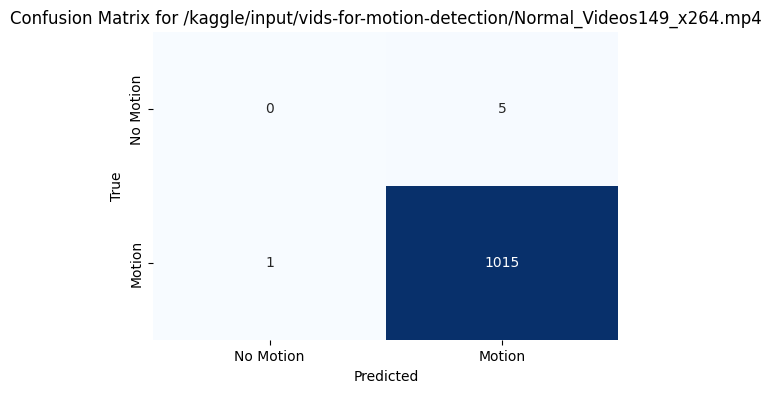

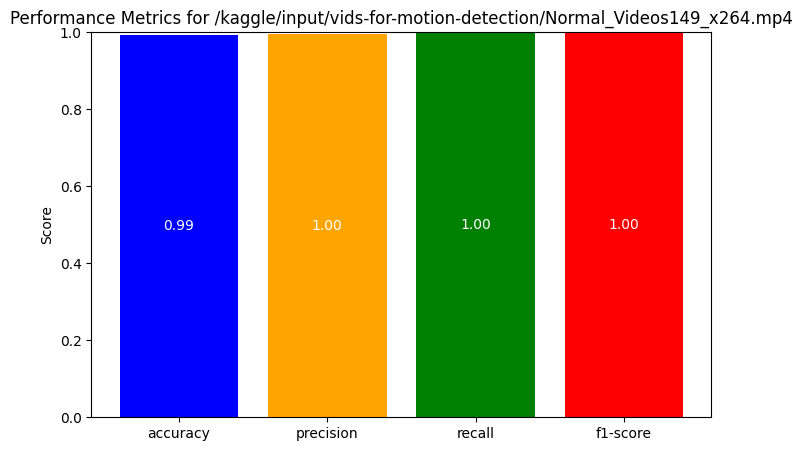

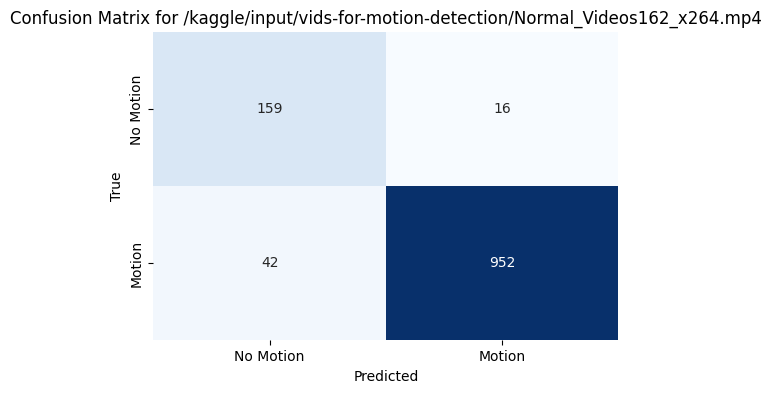

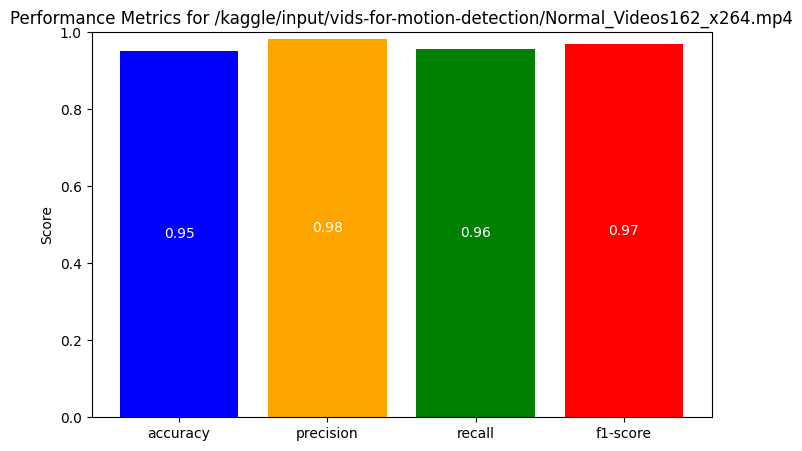

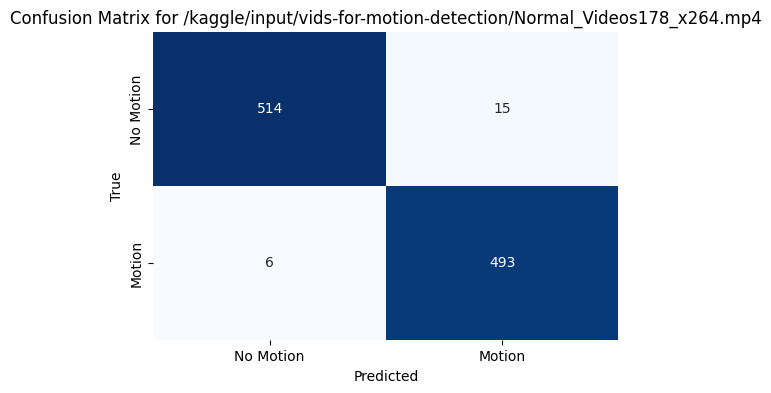

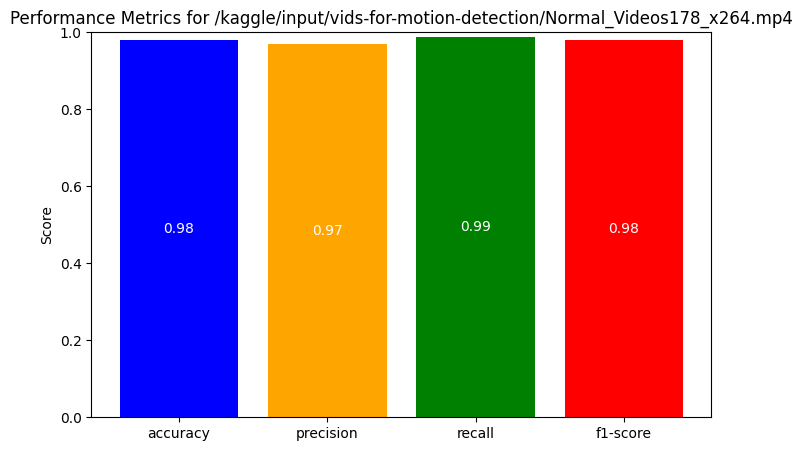

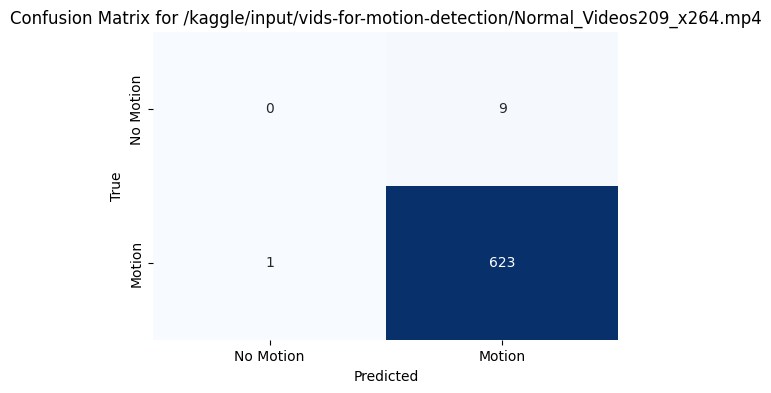

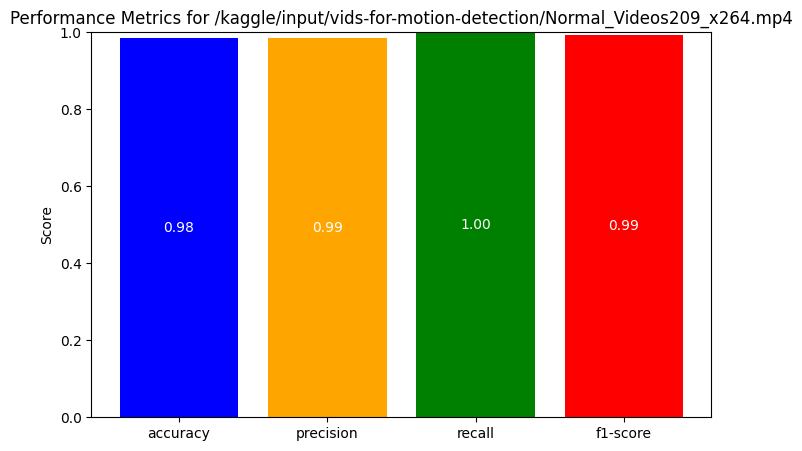

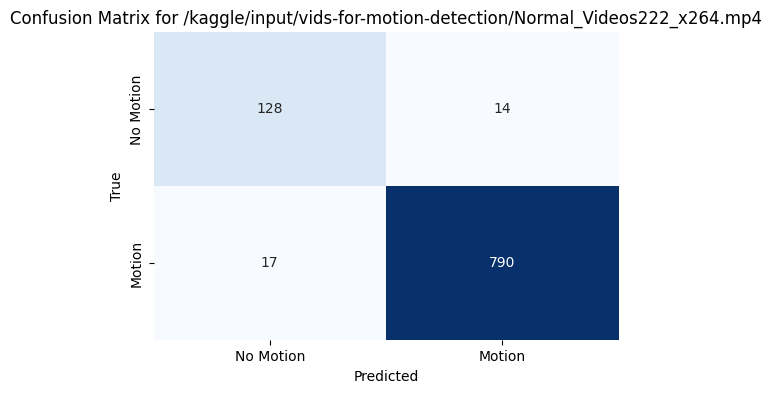

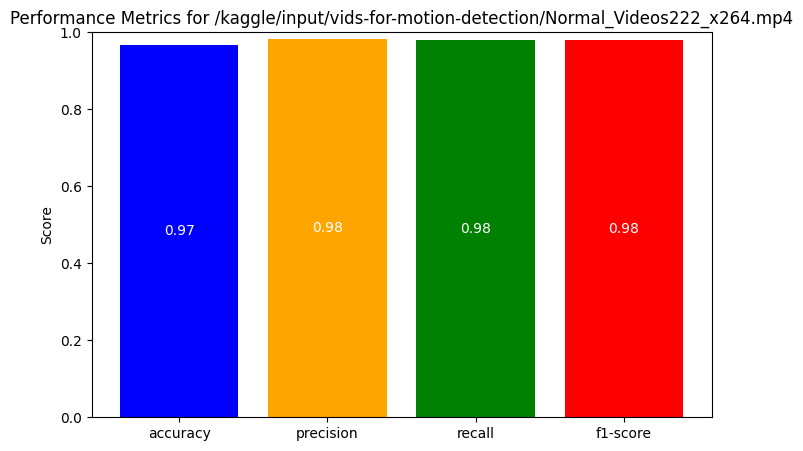

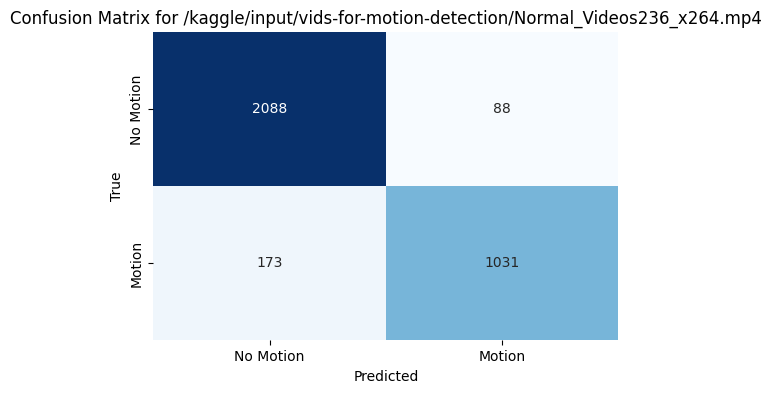

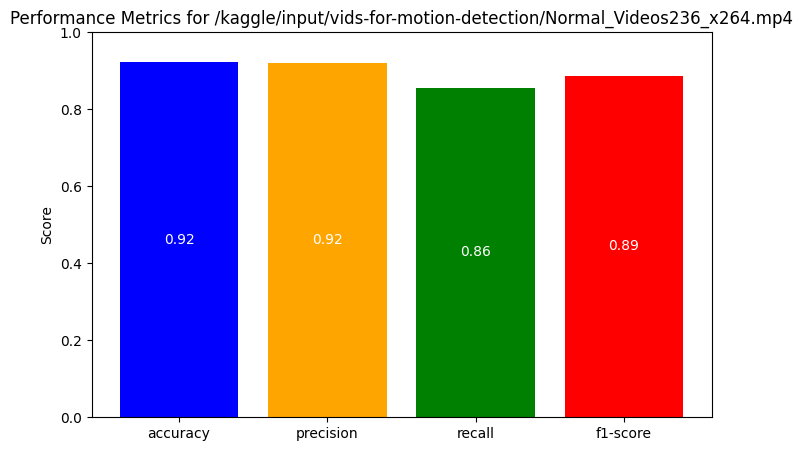

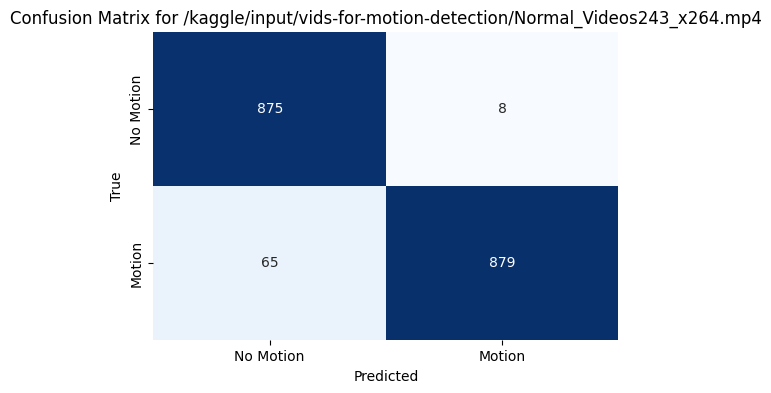

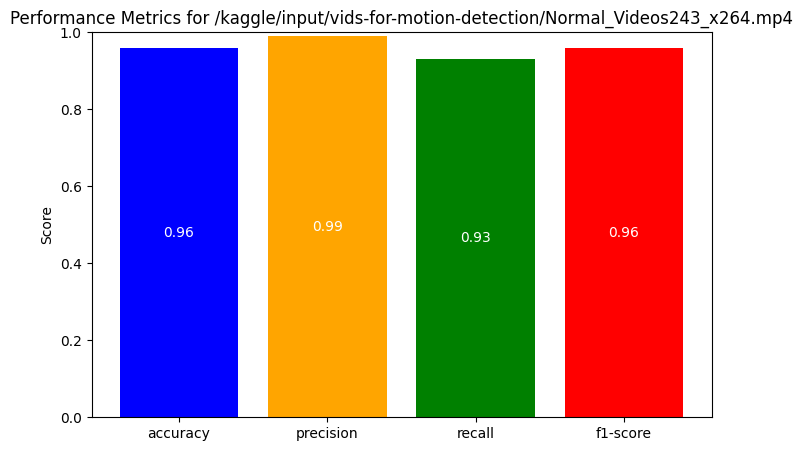

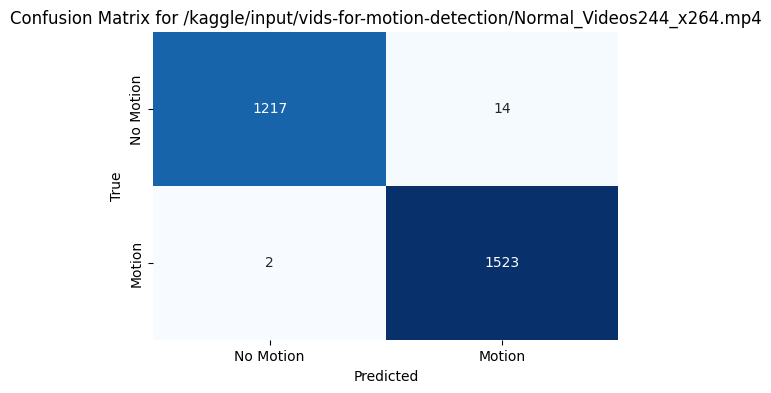

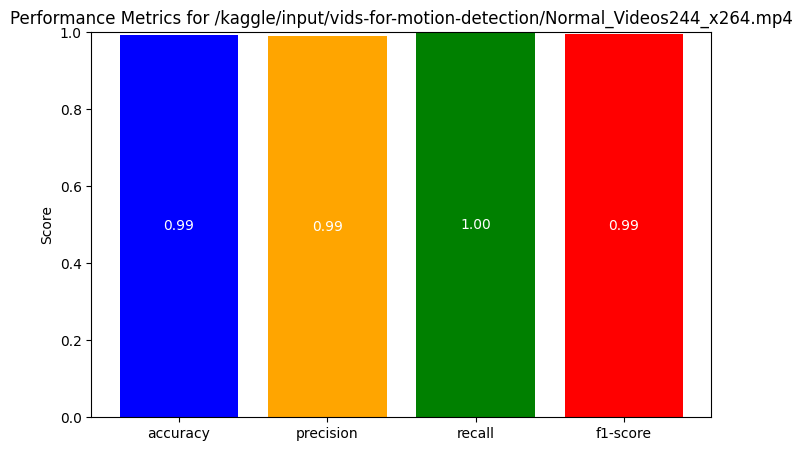

In [18]:
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load true labels and detected labels
true_labels_df = pd.read_csv('/kaggle/input/ground-truth-labels/ground_truth_labels.csv')  # Replace with your true labels CSV
detected_labels_df = pd.read_csv('/kaggle/working/motion_detected_labels.csv')  # The one generated with your labeling code

# Merge DataFrames on 'video_id' and 'frame_index'
merged_df = pd.merge(true_labels_df, detected_labels_df, on=['video_id', 'frame_index'], suffixes=('_true', '_detected'))

# Initialize a dictionary to store confusion matrices and metrics for each video
results = {}

# Initialize lists to store true and detected labels for overall metrics
all_y_true = []
all_y_pred = []

# Iterate through each unique video
for video_id in merged_df['video_id'].unique():
    video_data = merged_df[merged_df['video_id'] == video_id]
    
    # Extract true and detected labels
    y_true = video_data['label_true'].values
    y_pred = video_data['label_detected'].values
    
    # Store all true and predicted labels for overall metrics
    all_y_true.extend(y_true)
    all_y_pred.extend(y_pred)
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Calculate performance metrics
    report = classification_report(y_true, y_pred, output_dict=True)
    
    # Store results
    results[video_id] = {
        'confusion_matrix': cm,
        'accuracy': report['accuracy'],
        'precision': report['1']['precision'],  # Assuming 1 is the positive class
        'recall': report['1']['recall'],
        'f1-score': report['1']['f1-score']
    }

# Convert results to DataFrame for better readability
results_df = pd.DataFrame.from_dict(results, orient='index')

# Calculate overall performance metrics
overall_accuracy = accuracy_score(all_y_true, all_y_pred)
overall_precision = precision_score(all_y_true, all_y_pred, average='binary', pos_label=1)
overall_recall = recall_score(all_y_true, all_y_pred, average='binary', pos_label=1)
overall_f1_score = f1_score(all_y_true, all_y_pred, average='binary', pos_label=1)

# Print overall performance metrics
print("Overall Performance Metrics:")
print(f"Accuracy: {overall_accuracy:.2f}")
print(f"Precision: {overall_precision:.2f}")
print(f"Recall: {overall_recall:.2f}")
print(f"F1 Score: {overall_f1_score:.2f}")

# Plotting Confusion Matrices and Metrics
for video_id, metrics in results.items():
    # Plot confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(metrics['confusion_matrix'], annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix for {video_id}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(ticks=[0.5, 1.5], labels=['No Motion', 'Motion'])
    plt.yticks(ticks=[0.5, 1.5], labels=['No Motion', 'Motion'])
    plt.show()

    # Plot performance metrics
    plt.figure(figsize=(8, 5))
    metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1-score']
    scores = [metrics[m] for m in metrics_to_plot]
    
    bars = plt.bar(metrics_to_plot, scores, color=['blue', 'orange', 'green', 'red'])
    plt.ylim(0, 1)
    plt.title(f'Performance Metrics for {video_id}')
    plt.ylabel('Score')
    
    # Adding score annotations inside the bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval / 2, f'{yval:.2f}', ha='center', va='center', color='white')
    
    plt.show()
